In [1]:
# パッケージのimport
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import gym

In [2]:
# 動画の描画関数の宣言
# 参考URL http://nbviewer.jupyter.org/github/patrickmineault
# /xcorr-notebooks/blob/master/Render%20OpenAI%20gym%20as%20GIF.ipynb
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0),
               dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),
                                   interval=50)

    anim.save('movie_cartpole_DDQN.mp4')  # 動画のファイル名と保存です
    display(display_animation(anim, default_mode='loop'))

In [3]:
# namedtupleを生成
from collections import namedtuple

Transition = namedtuple(
    'Transition', ('state', 'action', 'next_state', 'reward'))

In [4]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
GAMMA = 0.99  # 時間割引率
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES = 500  # 最大試行回数


In [5]:
# 経験を保存するメモリクラスを定義します


class ReplayMemory:

    def __init__(self, CAPACITY):
        self.capacity = CAPACITY  # メモリの最大長さ
        self.memory = []  # 経験を保存する変数
        self.index = 0  # 保存するindexを示す変数

    def push(self, state, action, state_next, reward):
        '''transition = (state, action, state_next, reward)をメモリに保存する'''

        if len(self.memory) < self.capacity:
            self.memory.append(None)  # メモリが満タンでないときは足す

        # namedtupleのTransitionを使用し、値とフィールド名をペアにして保存します
        self.memory[self.index] = Transition(state, action, state_next, reward)

        self.index = (self.index + 1) % self.capacity  # 保存するindexを1つずらす

    def sample(self, batch_size):
        '''batch_size分だけ、ランダムに保存内容を取り出す'''
        return random.sample(self.memory, batch_size)

    def __len__(self):
        '''関数lenに対して、現在の変数memoryの長さを返す'''
        return len(self.memory)

In [6]:

# ディープ・ニューラルネットワークの構築
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self, n_in, n_mid, n_out):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n_in, n_mid)
        self.fc2 = nn.Linear(n_mid, n_mid)
        self.fc3 = nn.Linear(n_mid, n_out)

    def forward(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

In [7]:
# エージェントが持つ脳となるクラスです、DDQNを実行します

import random
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

BATCH_SIZE = 32
CAPACITY = 10000


class Brain:
    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # 経験を記憶するメモリオブジェクトを生成
        self.memory = ReplayMemory(CAPACITY)

        # ニューラルネットワークを構築
        n_in, n_mid, n_out = num_states, 32, num_actions
        self.main_q_network = Net(n_in, n_mid, n_out)  # Netクラスを使用
        self.target_q_network = Net(n_in, n_mid, n_out)  # Netクラスを使用
        print(self.main_q_network)  # ネットワークの形を出力

        # 最適化手法の設定
        self.optimizer = optim.Adam(
            self.main_q_network.parameters(), lr=0.0001)

    def replay(self):
        '''Experience Replayでネットワークの結合パラメータを学習'''

        # 1. メモリサイズの確認
        if len(self.memory) < BATCH_SIZE:
            return

        # 2. ミニバッチの作成
        self.batch, self.state_batch, self.action_batch, self.reward_batch, self.non_final_next_states = self.make_minibatch()

        # 3. 教師信号となるQ(s_t, a_t)値を求める
        self.expected_state_action_values = self.get_expected_state_action_values()

        # 4. 結合パラメータの更新
        self.update_main_q_network()

    def decide_action(self, state, episode):
        '''現在の状態に応じて、行動を決定する'''
        # ε-greedy法で徐々に最適行動のみを採用する
        epsilon = 0.5 * (1 / (episode + 1))

        if epsilon <= np.random.uniform(0, 1):
            self.main_q_network.eval()  # ネットワークを推論モードに切り替える
            with torch.no_grad():
                action = self.main_q_network(state).max(1)[1].view(1, 1)
            # ネットワークの出力の最大値のindexを取り出します = max(1)[1]
            # .view(1,1)は[torch.LongTensor of size 1]　を size 1x1 に変換します

        else:
            # 0,1の行動をランダムに返す
            action = torch.LongTensor(
                [[random.randrange(self.num_actions)]])  # 0,1の行動をランダムに返す
            # actionは[torch.LongTensor of size 1x1]の形になります

        return action

    def make_minibatch(self):
        '''2. ミニバッチの作成'''

        # 2.1 メモリからミニバッチ分のデータを取り出す
        transitions = self.memory.sample(BATCH_SIZE)

        # 2.2 各変数をミニバッチに対応する形に変形
        # transitionsは1stepごとの(state, action, state_next, reward)が、BATCH_SIZE分格納されている
        # つまり、(state, action, state_next, reward)×BATCH_SIZE
        # これをミニバッチにしたい。つまり
        # (state×BATCH_SIZE, action×BATCH_SIZE, state_next×BATCH_SIZE, reward×BATCH_SIZE)にする
        batch = Transition(*zip(*transitions))

        # 2.3 各変数の要素をミニバッチに対応する形に変形し、ネットワークで扱えるようVariableにする
        # 例えばstateの場合、[torch.FloatTensor of size 1x4]がBATCH_SIZE分並んでいるのですが、
        # それを torch.FloatTensor of size BATCH_SIZEx4 に変換します
        # 状態、行動、報酬、non_finalの状態のミニバッチのVariableを作成
        # catはConcatenates（結合）のことです。
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])

        return batch, state_batch, action_batch, reward_batch, non_final_next_states

    def get_expected_state_action_values(self):
        '''3. 教師信号となるQ(s_t, a_t)値を求める'''

        # 3.1 ネットワークを推論モードに切り替える
        self.main_q_network.eval()
        self.target_q_network.eval()

        # 3.2 ネットワークが出力したQ(s_t, a_t)を求める
        # self.model(state_batch)は、右左の両方のQ値を出力しており
        # [torch.FloatTensor of size BATCH_SIZEx2]になっている。
        # ここから実行したアクションa_tに対応するQ値を求めるため、action_batchで行った行動a_tが右か左かのindexを求め
        # それに対応するQ値をgatherでひっぱり出す。
        self.state_action_values = self.main_q_network(
            self.state_batch).gather(1, self.action_batch)

        # 3.3 max{Q(s_t+1, a)}値を求める。ただし次の状態があるかに注意。

        # cartpoleがdoneになっておらず、next_stateがあるかをチェックするインデックスマスクを作成
        non_final_mask = torch.ByteTensor(tuple(map(lambda s: s is not None,
                                                    self.batch.next_state)))
        # まずは全部0にしておく
        next_state_values = torch.zeros(BATCH_SIZE)

        a_m = torch.zeros(BATCH_SIZE).type(torch.LongTensor)

        # 次の状態での最大Q値の行動a_mをMain Q-Networkから求める
        # 最後の[1]で行動に対応したindexが返る
        a_m[non_final_mask] = self.main_q_network(
            self.non_final_next_states).detach().max(1)[1]

        # 次の状態があるものだけにフィルターし、size 32を32×1へ
        a_m_non_final_next_states = a_m[non_final_mask].view(-1, 1)

        # 次の状態があるindexの、行動a_mのQ値をtarget Q-Networkから求める
        # detach()で取り出す
        # squeeze()でsize[minibatch×1]を[minibatch]に。
        next_state_values[non_final_mask] = self.target_q_network(
            self.non_final_next_states).gather(1, a_m_non_final_next_states).detach().squeeze()

        # 3.4 教師となるQ(s_t, a_t)値を、Q学習の式から求める
        expected_state_action_values = self.reward_batch + GAMMA * next_state_values

        return expected_state_action_values

    def update_main_q_network(self):
        '''4. 結合パラメータの更新'''

        # 4.1 ネットワークを訓練モードに切り替える
        self.main_q_network.train()

        # 4.2 損失関数を計算する（smooth_l1_lossはHuberloss）
        # expected_state_action_valuesは
        # sizeが[minbatch]になっているので、unsqueezeで[minibatch x 1]へ
        loss = F.smooth_l1_loss(self.state_action_values,
                                self.expected_state_action_values.unsqueeze(1))

        # 4.3 結合パラメータを更新する
        self.optimizer.zero_grad()  # 勾配をリセット
        loss.backward()  # バックプロパゲーションを計算
        self.optimizer.step()  # 結合パラメータを更新

    def update_target_q_network(self):  # DDQNで追加
        '''Target Q-NetworkをMainと同じにする'''
        self.target_q_network.load_state_dict(self.main_q_network.state_dict())

In [8]:
# CartPoleで動くエージェントクラスです、棒付き台車そのものになります


class Agent:
    def __init__(self, num_states, num_actions):
        '''課題の状態と行動の数を設定する'''
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_q_function(self):
        '''Q関数を更新する'''
        self.brain.replay()

    def get_action(self, state, episode):
        '''行動を決定する'''
        action = self.brain.decide_action(state, episode)
        return action

    def memorize(self, state, action, state_next, reward):
        '''memoryオブジェクトに、state, action, state_next, rewardの内容を保存する'''
        self.brain.memory.push(state, action, state_next, reward)

    def update_target_q_function(self):
        '''Target Q-NetworkをMain Q-Networkと同じに更新'''
        self.brain.update_target_q_network()

In [13]:
# CartPoleを実行する環境のクラスです


class Environment:

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態と行動の数を設定
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        # 環境内で行動するAgentを生成
        self.agent = Agent(num_states, num_actions)

    def run(self):
        '''実行'''
        episode_10_list = np.zeros(10)  # 10試行分の立ち続けたstep数を格納し、平均ステップ数を出力に利用
        complete_episodes = 0  # 195step以上連続で立ち続けた試行数
        episode_final = False  # 最後の試行フラグ
        frames = []  # 最後の試行を動画にするために画像を格納する変数

        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化

            state = observation  # 観測をそのまま状態sとして使用
            state = torch.from_numpy(state).type(
                torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
            state = torch.unsqueeze(state, 0)  # size 4をsize 1x4に変換

            for step in range(MAX_STEPS):  # 1エピソードのループ
                
                # 動画描画をコメントアウトしています
                if episode_final is True:  # 最終試行ではframesに各時刻の画像を追加していく
                    frames.append(self.env.render(mode='rgb_array'))
                    
                action = self.agent.get_action(state, episode)  # 行動を求める

                # 行動a_tの実行により、s_{t+1}とdoneフラグを求める
                # actionから.item()を指定して、中身を取り出す
                observation_next, _, done, _ = self.env.step(
                    action.item())  # rewardとinfoは使わないので_にする

                # 報酬を与える。さらにepisodeの終了評価と、state_nextを設定する
                if done:  # ステップ数が200経過するか、一定角度以上傾くとdoneはtrueになる
                    state_next = None  # 次の状態はないので、Noneを格納

                    # 直近10episodeの立てたstep数リストに追加
                    episode_10_list = np.hstack(
                        (episode_10_list[1:], step + 1))

                    if step < 195:
                        reward = torch.FloatTensor(
                            [-1.0])  # 途中でこけたら罰則として報酬-1を与える
                        complete_episodes = 0  # 連続成功記録をリセット
                    else:
                        reward = torch.FloatTensor([1.0])  # 立ったまま終了時は報酬1を与える
                        complete_episodes = complete_episodes + 1  # 連続記録を更新
                else:
                    reward = torch.FloatTensor([0.0])  # 普段は報酬0
                    state_next = observation_next  # 観測をそのまま状態とする
                    state_next = torch.from_numpy(state_next).type(
                        torch.FloatTensor)  # numpy変数をPyTorchのテンソルに変換
                    state_next = torch.unsqueeze(state_next, 0)  # size 4をsize 1x4に変換

                # メモリに経験を追加
                self.agent.memorize(state, action, state_next, reward)

                # Experience ReplayでQ関数を更新する
                self.agent.update_q_function()

                # 観測の更新
                state = state_next

                # 終了時の処理
                if done:
                    print('%d Episode: Finished after %d steps：10試行の平均step数 = %.1lf' % (
                        episode, step + 1, episode_10_list.mean()))
                    
                    # DDQNで追加、2試行に1度、Target Q-NetworkをMainと同じにコピーする
                    if(episode % 2 == 0):
                        self.agent.update_target_q_function()
                    break
                    
                    
            if episode_final is True:
                # 動画描画をコメントアウトしています
                # 動画を保存と描画
                display_frames_as_gif(frames)
                break

            # 10連続で200step経ち続けたら成功
            if complete_episodes >= 10:
                print('10回連続成功')
                episode_final = True  # 次の試行を描画を行う最終試行とする

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
Net(
  (fc1): Linear(in_features=4, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)
0 Episode: Finished after 26 steps：10試行の平均step数 = 2.6
1 Episode: Finished after 9 steps：10試行の平均step数 = 3.5
2 Episode: Finished after 10 steps：10試行の平均step数 = 4.5
3 Episode: Finished after 12 steps：10試行の平均step数 = 5.7
4 Episode: Finished after 9 steps：10試行の平均step数 = 6.6
5 Episode: Finished after 12 steps：10試行の平均step数 = 7.8
6 Episode: Finished after 11 steps：10試行の平均step数 = 8.9
7 Episode: Finished after 10 steps：10試行の平均step数 = 9.9
8 Episode: Finished after 10 steps：10試行の平均step数 = 10.9
9 Episode: Finished after 10 steps：10試行の平均step数 = 11.9
10 Episode: Finished after 9 steps：10試行の平均step数 = 10.2
11 Episode: Finished after 10 steps：10試行の平均step数 = 10.3
12 Episode: Finished after 8 steps：10試行の平均step数 = 10.1
13 Episode

140 Episode: Finished after 200 steps：10試行の平均step数 = 191.0
141 Episode: Finished after 200 steps：10試行の平均step数 = 193.0
142 Episode: Finished after 190 steps：10試行の平均step数 = 194.3
143 Episode: Finished after 200 steps：10試行の平均step数 = 194.9
144 Episode: Finished after 200 steps：10試行の平均step数 = 196.6
145 Episode: Finished after 200 steps：10試行の平均step数 = 196.6
146 Episode: Finished after 177 steps：10試行の平均step数 = 194.3
147 Episode: Finished after 200 steps：10試行の平均step数 = 194.3
148 Episode: Finished after 161 steps：10試行の平均step数 = 190.4
149 Episode: Finished after 155 steps：10試行の平均step数 = 188.3
150 Episode: Finished after 192 steps：10試行の平均step数 = 187.5
151 Episode: Finished after 200 steps：10試行の平均step数 = 187.5
152 Episode: Finished after 200 steps：10試行の平均step数 = 188.5
153 Episode: Finished after 188 steps：10試行の平均step数 = 187.3
154 Episode: Finished after 164 steps：10試行の平均step数 = 183.7
155 Episode: Finished after 198 steps：10試行の平均step数 = 183.5
156 Episode: Finished after 162 steps：10試行の平均step数 = 182


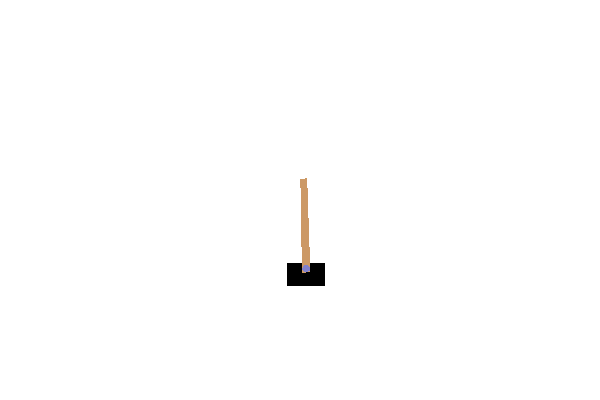
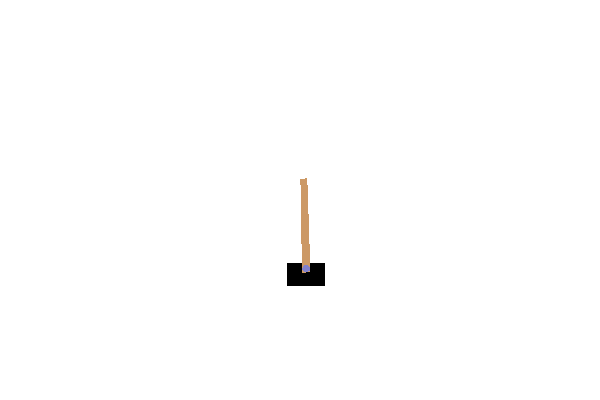
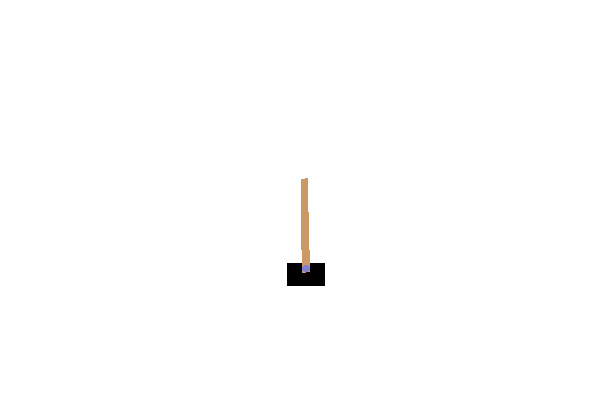
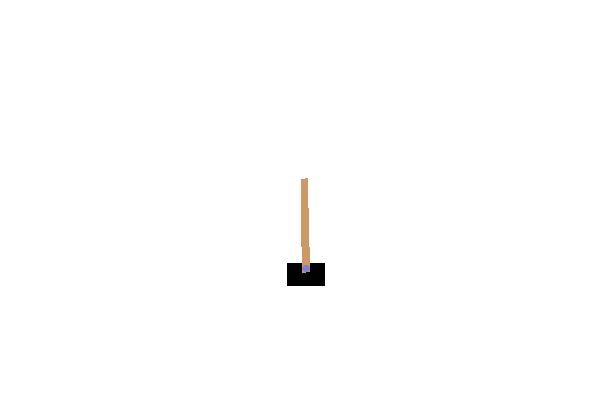
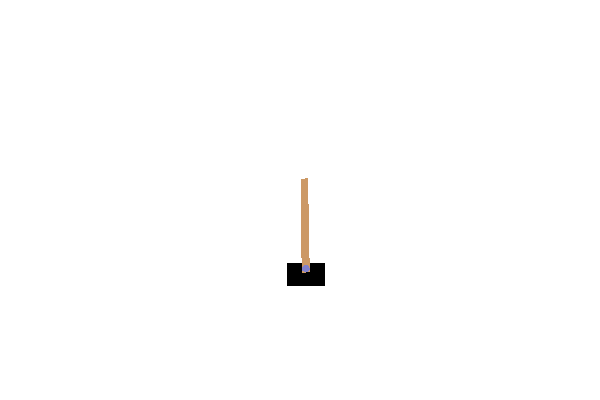
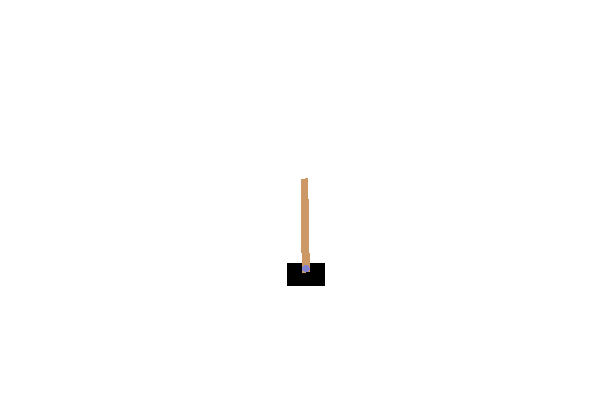
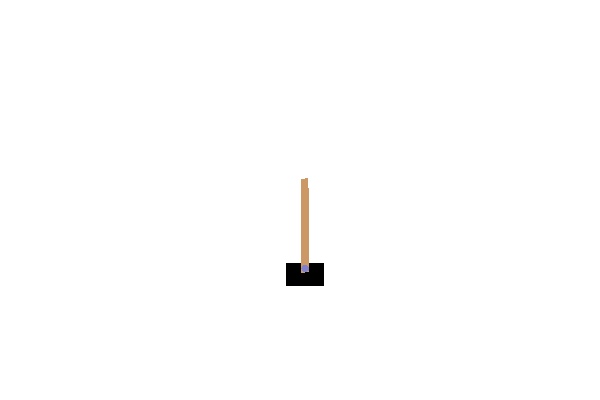
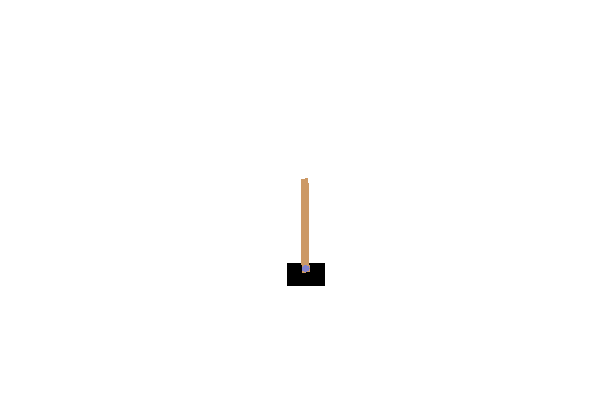
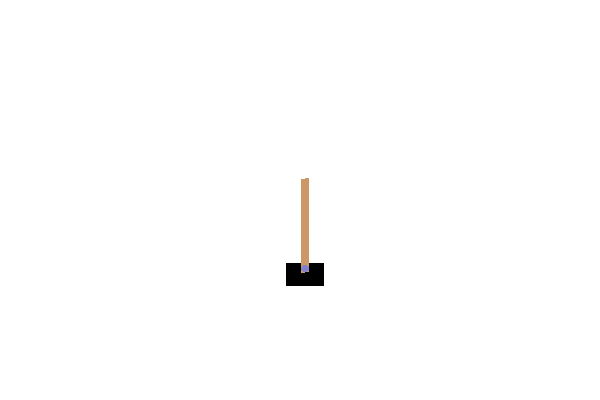
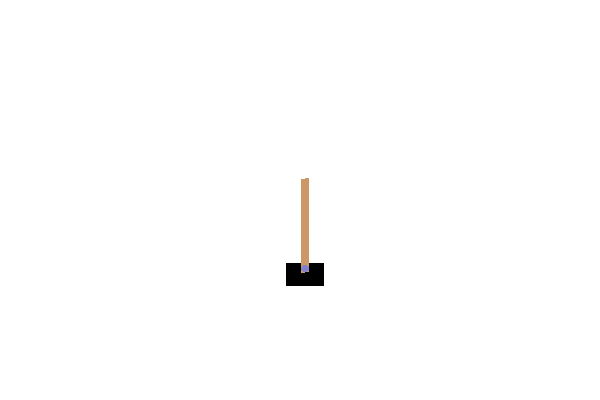
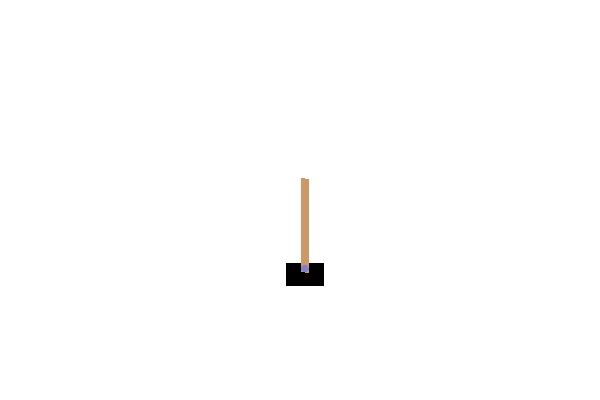
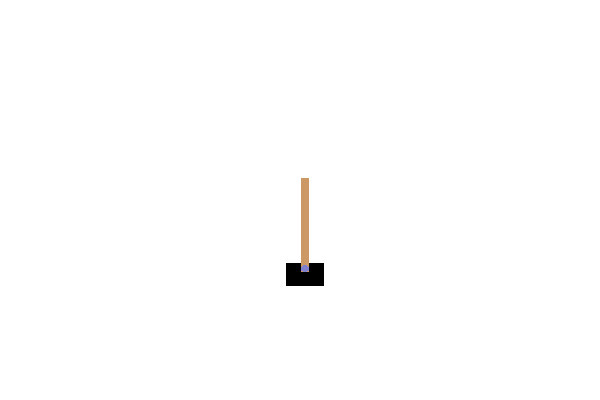
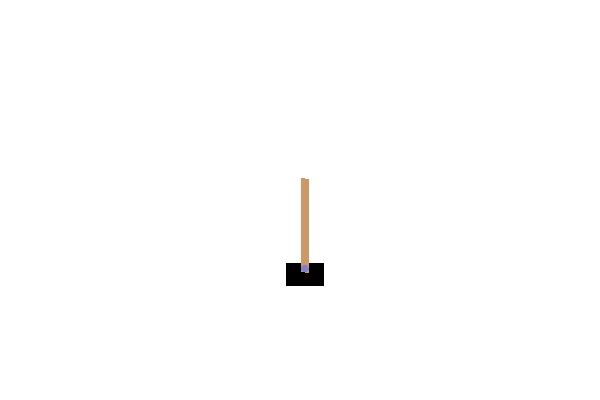
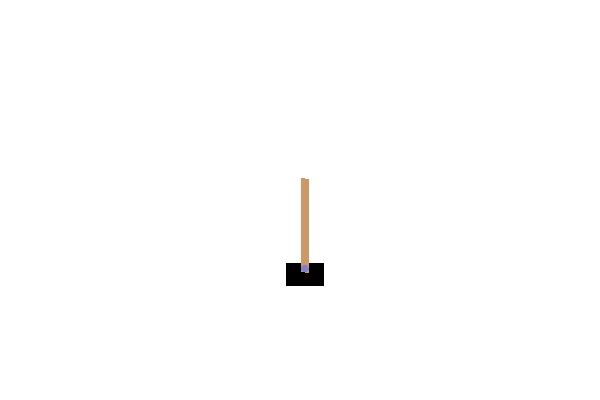
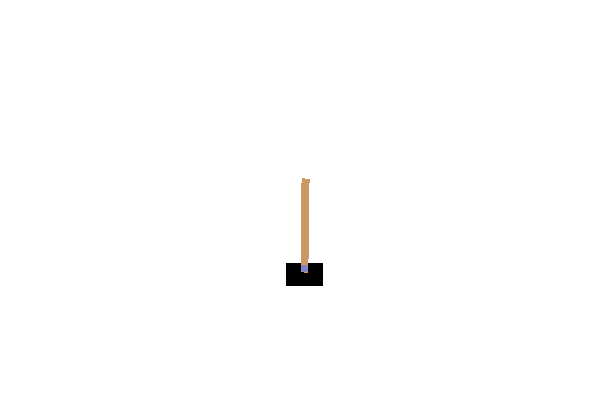
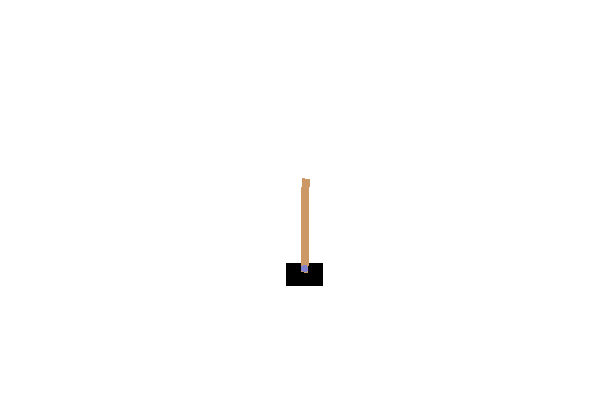
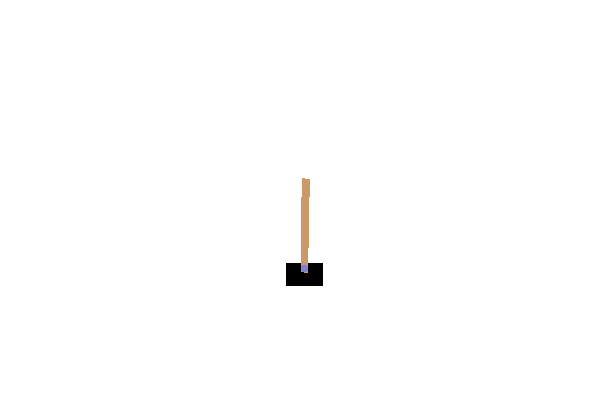
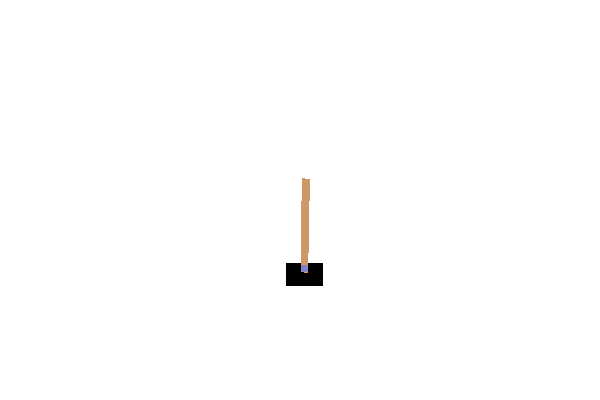
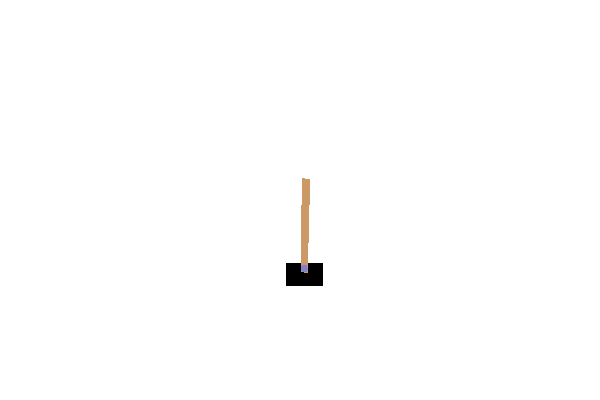
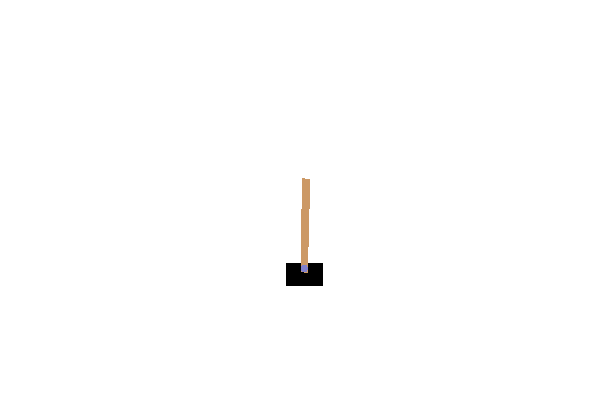
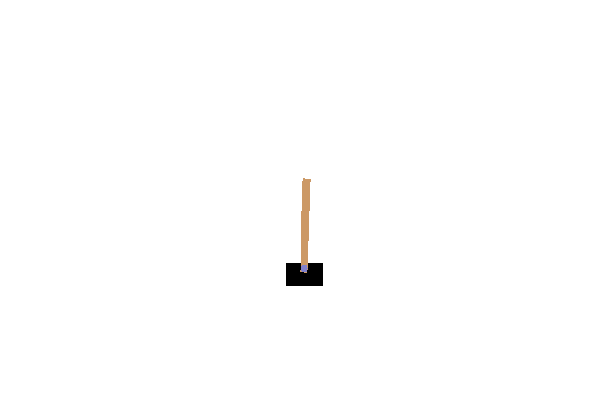
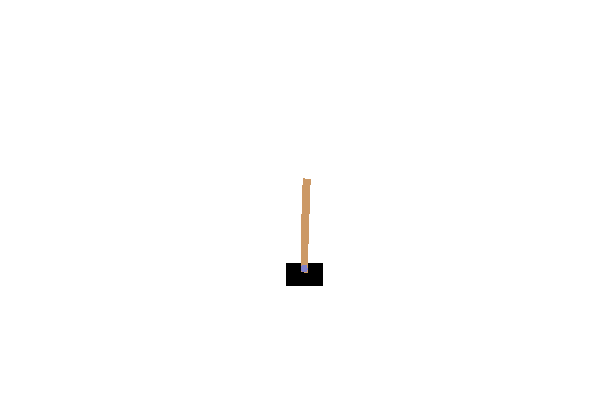
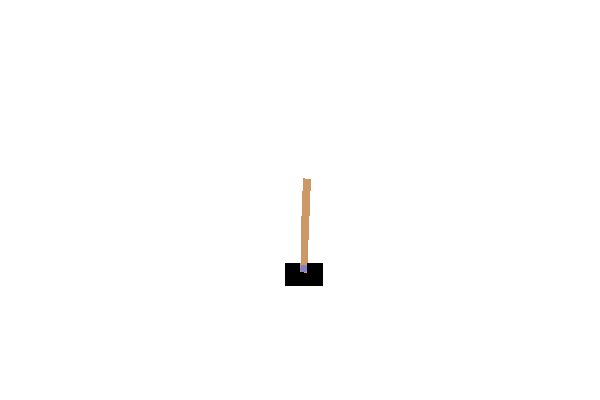
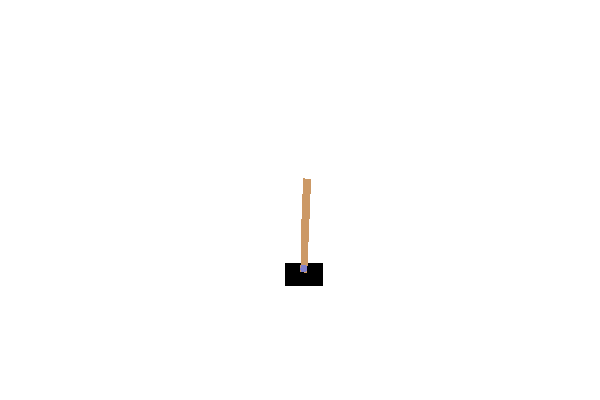
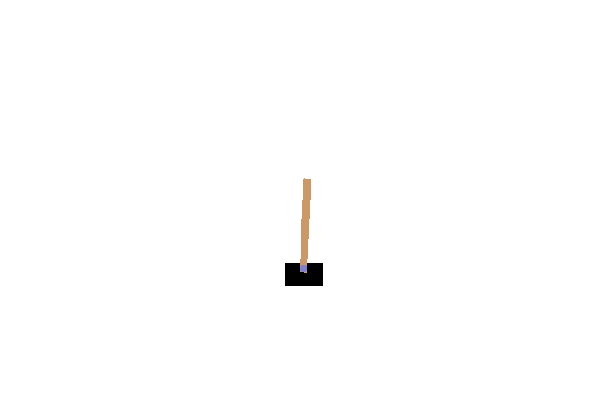
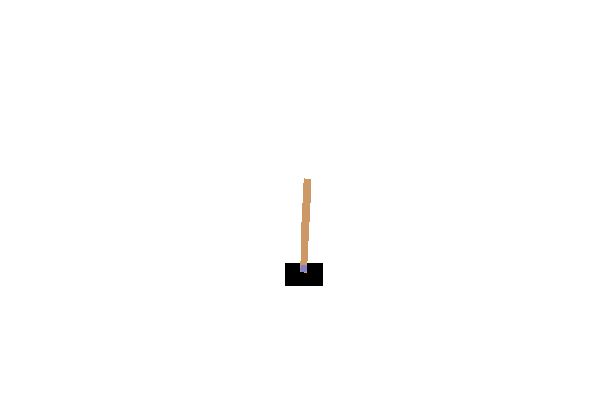
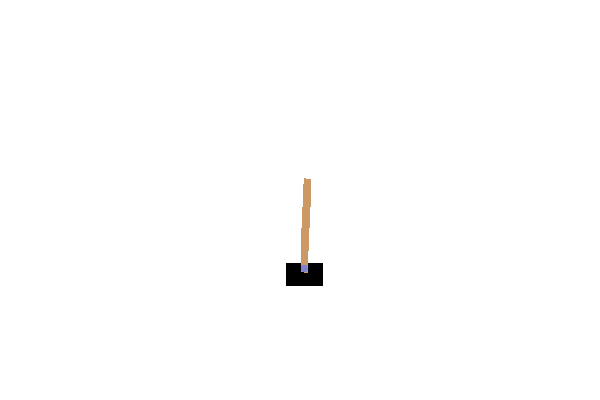
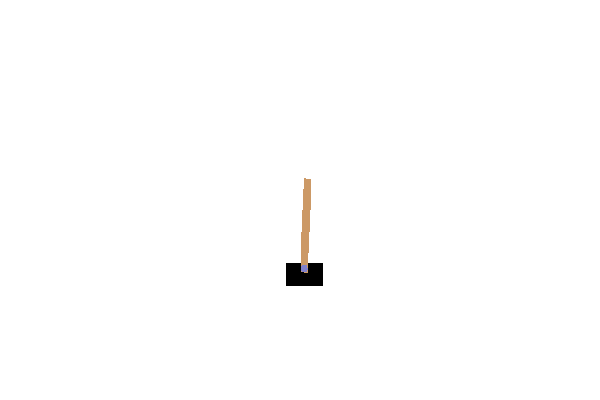
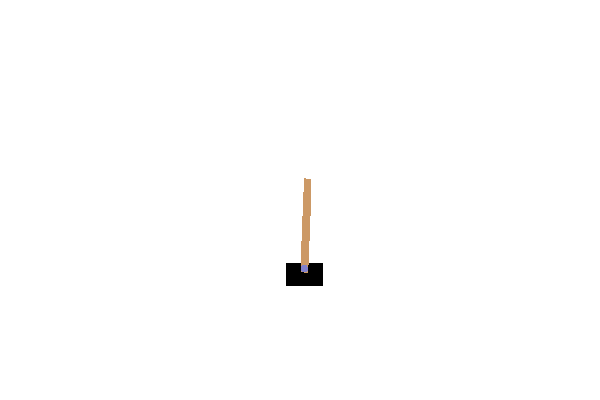
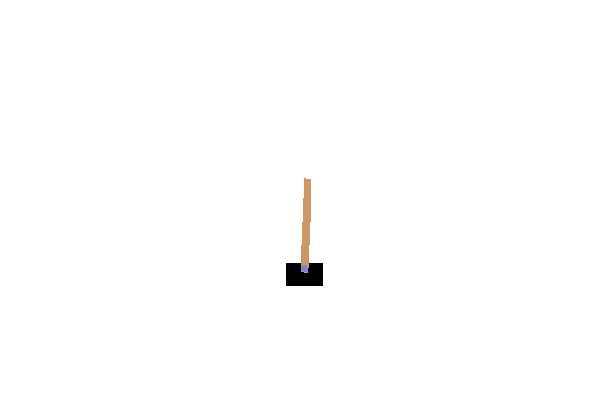
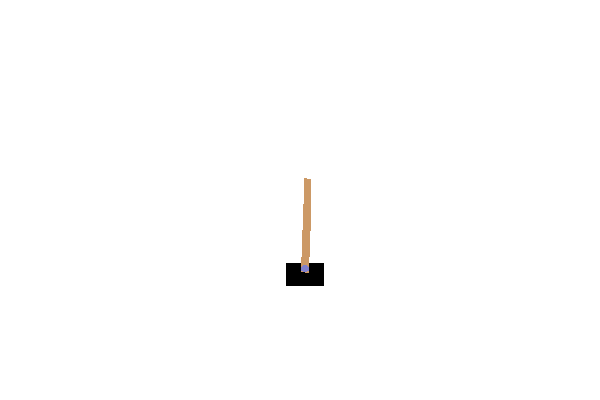
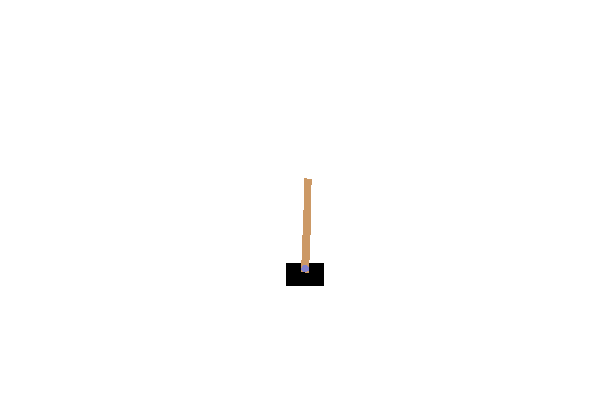
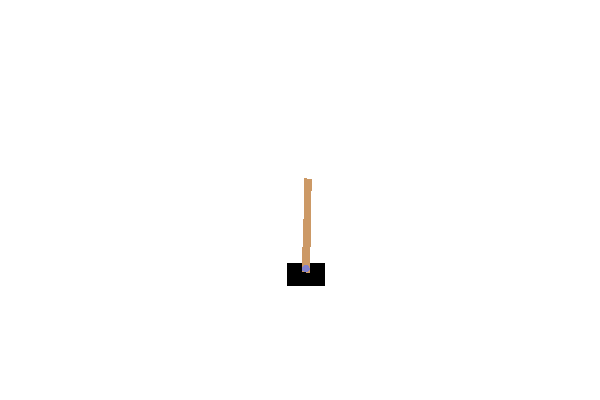
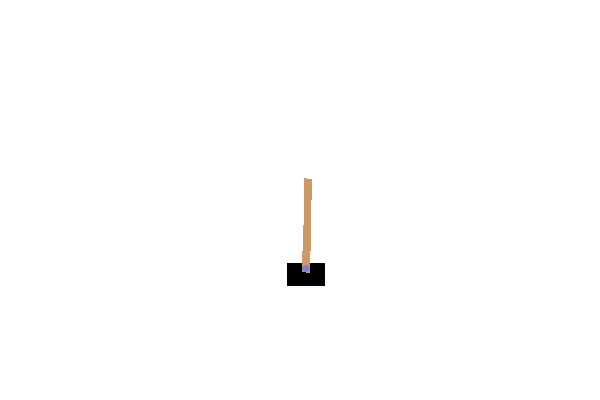
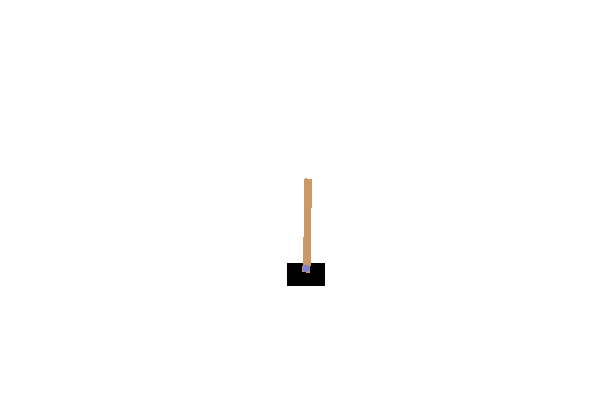
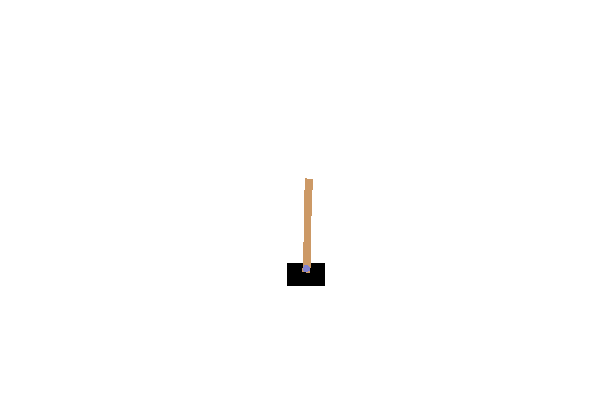
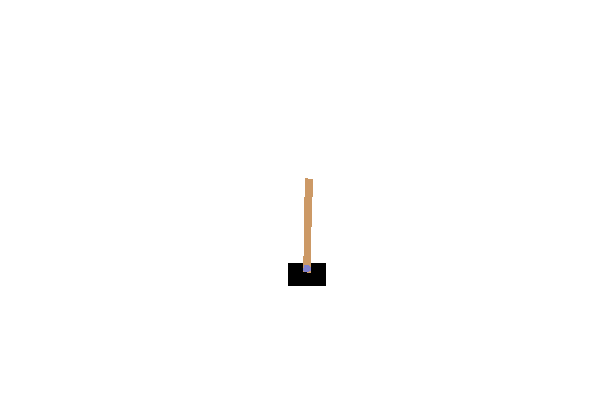
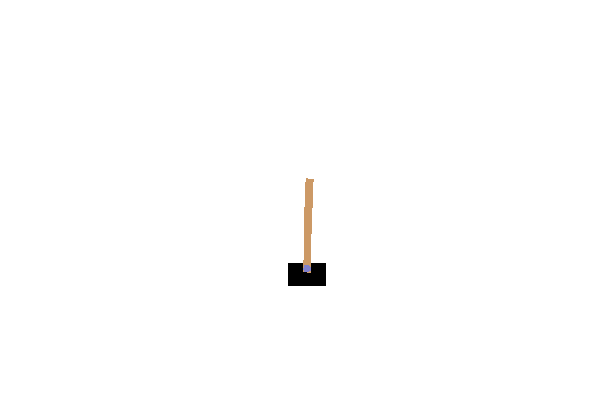
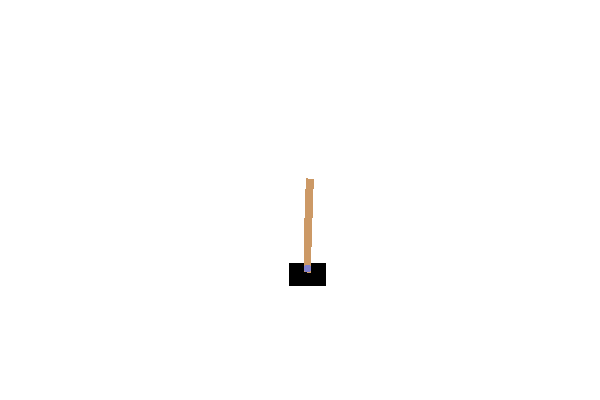
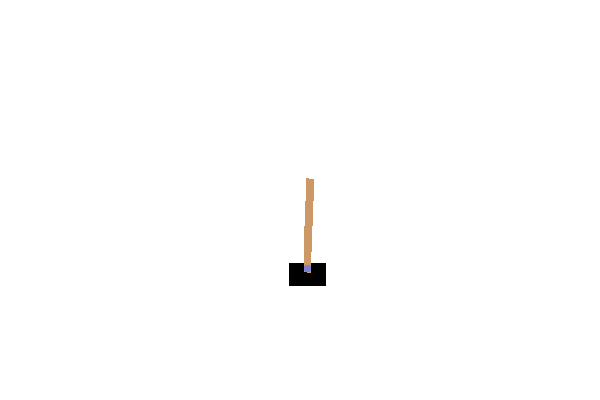
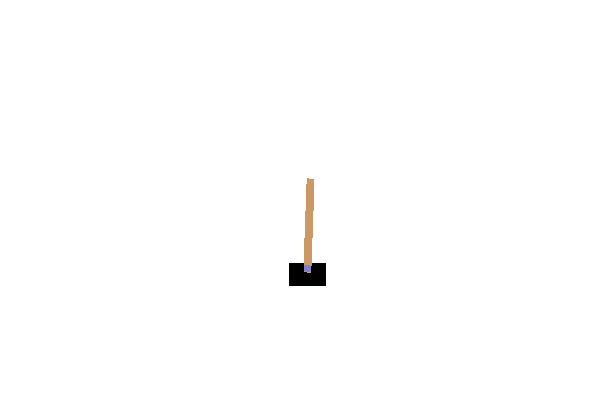
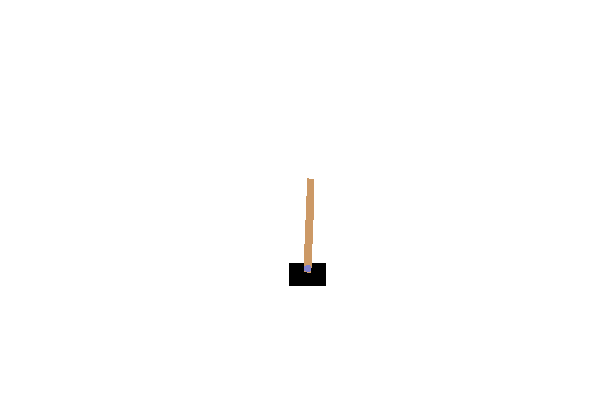
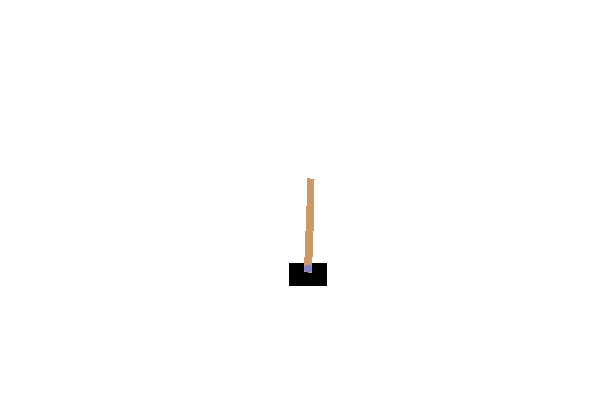
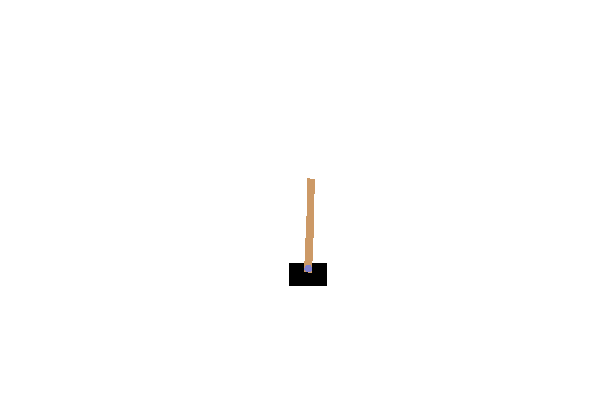
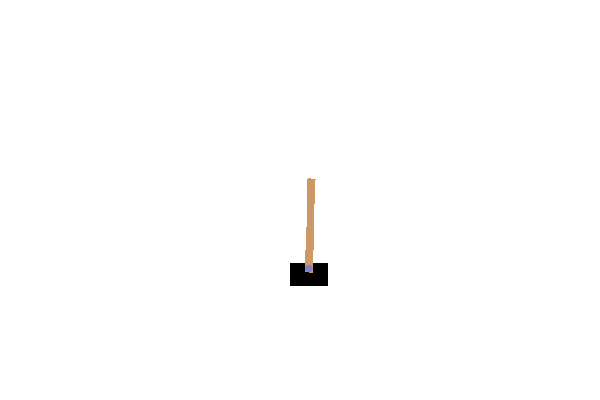
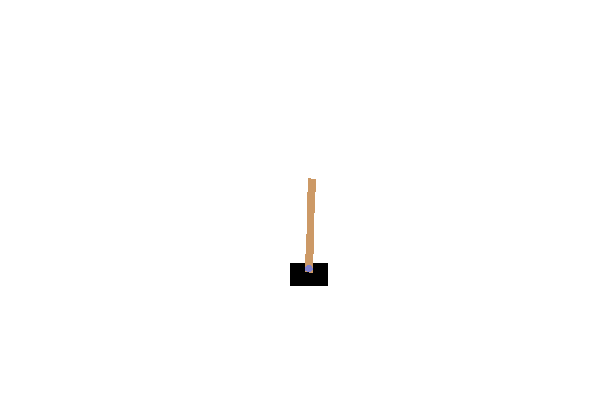
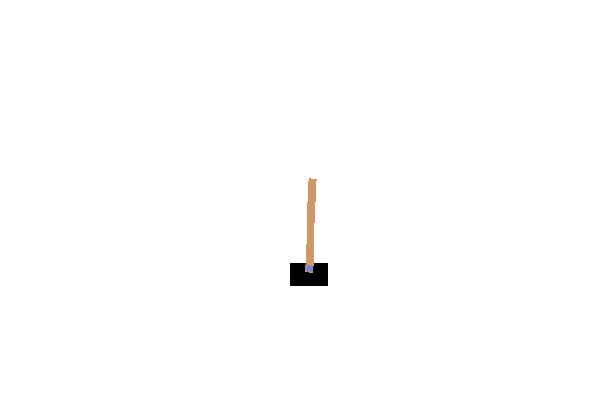
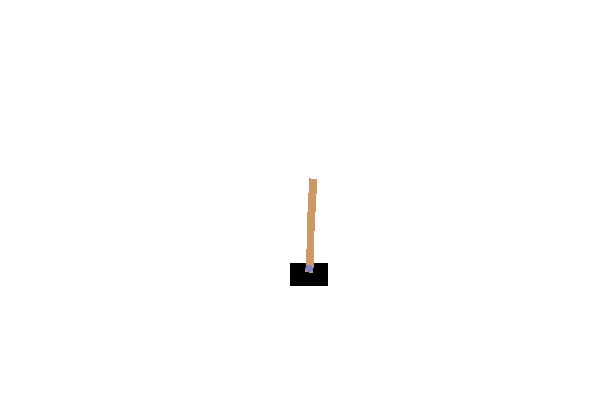
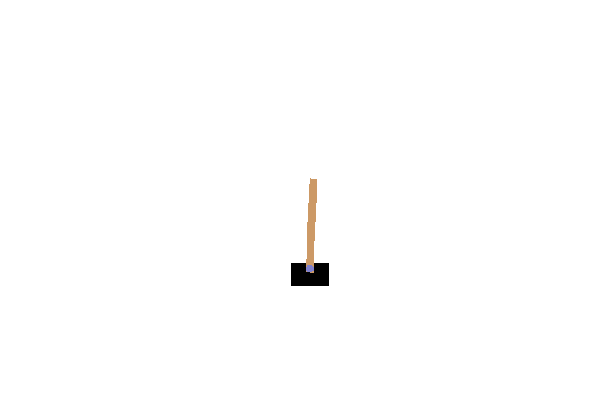
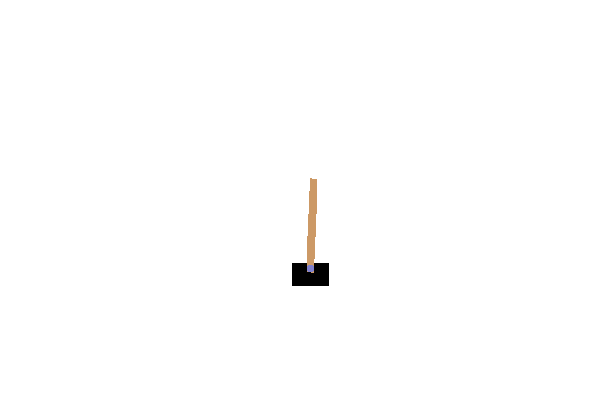
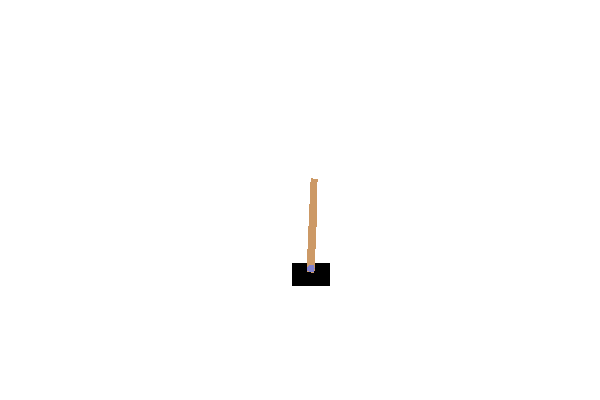
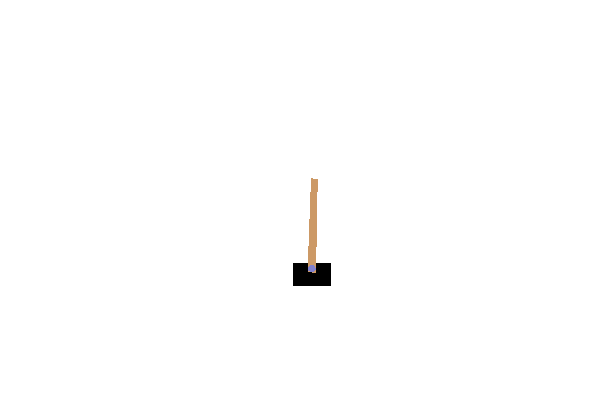
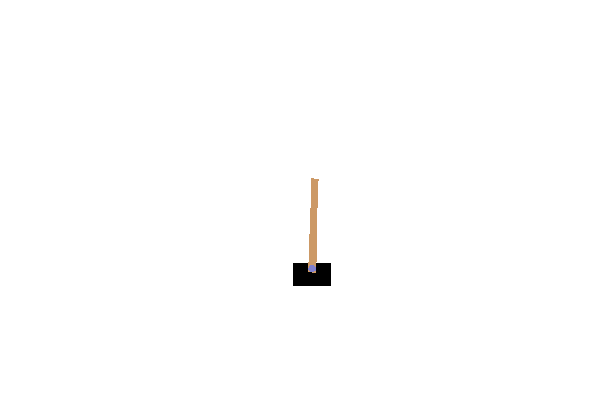
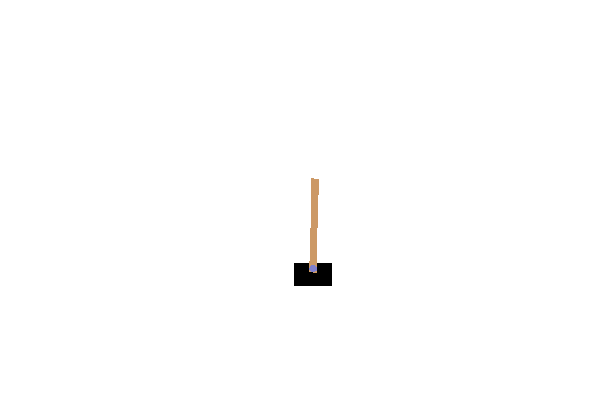
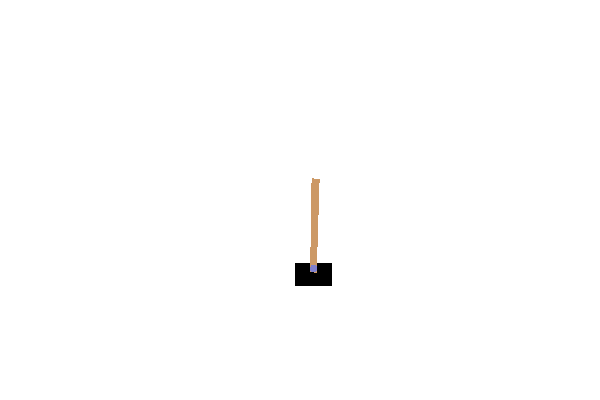
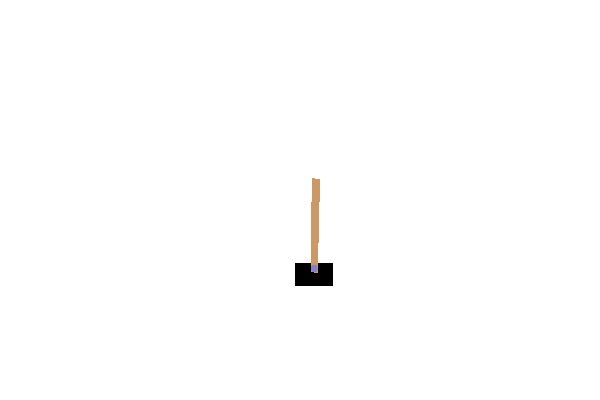
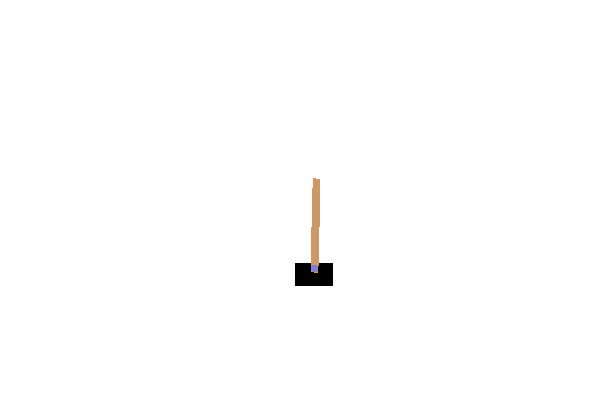
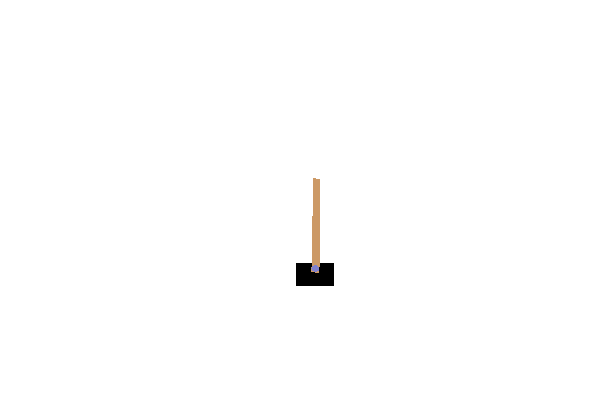
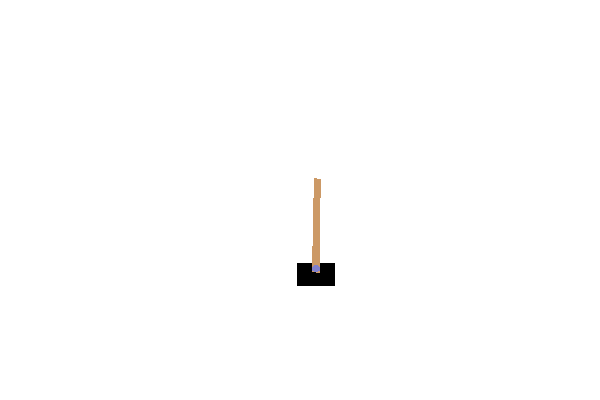
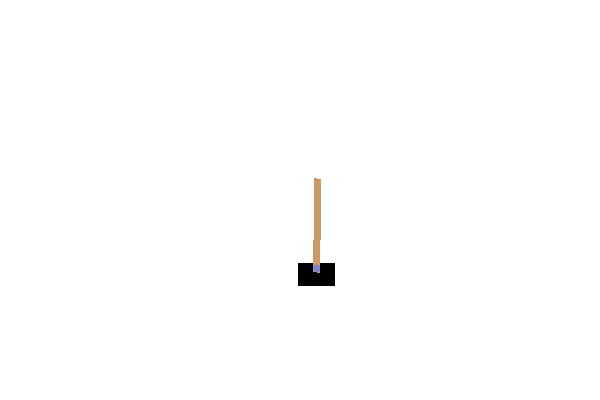
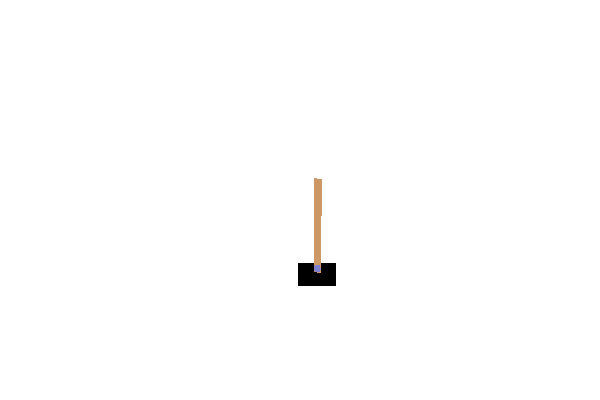
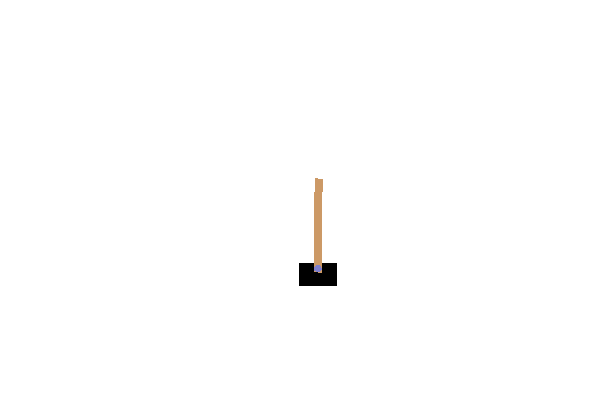
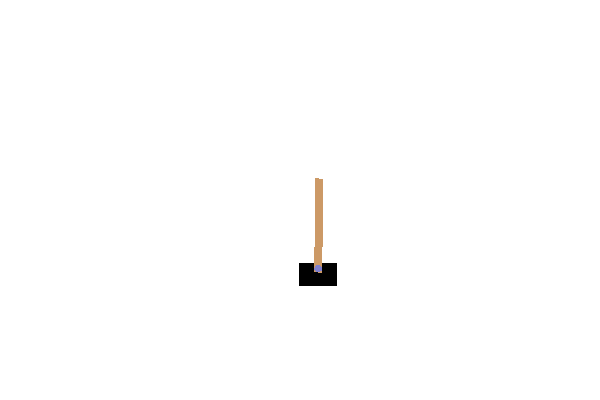
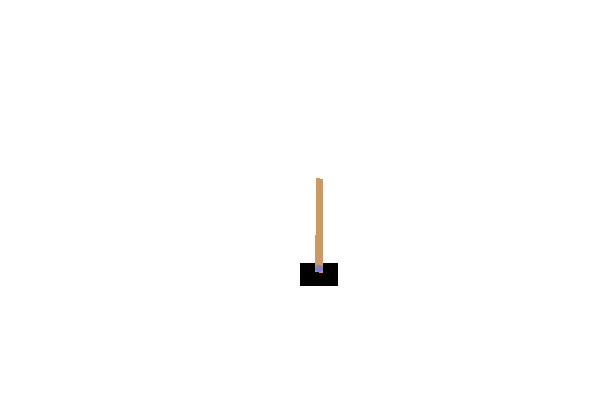
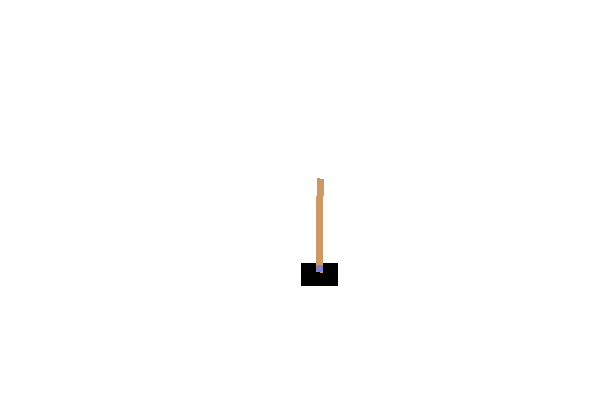
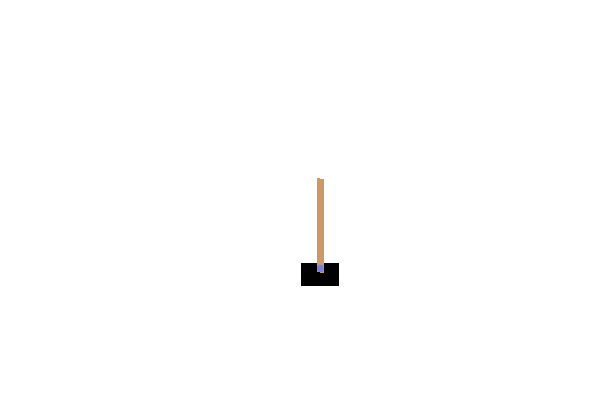
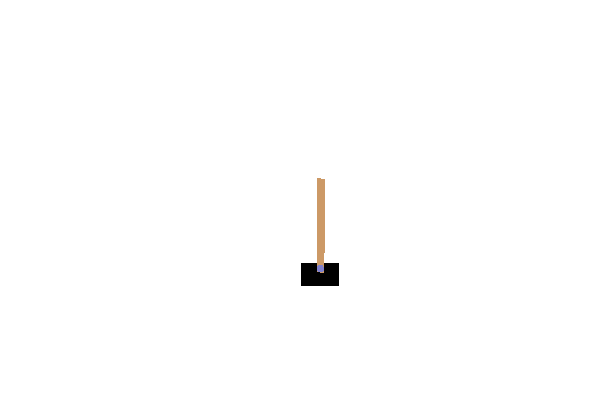
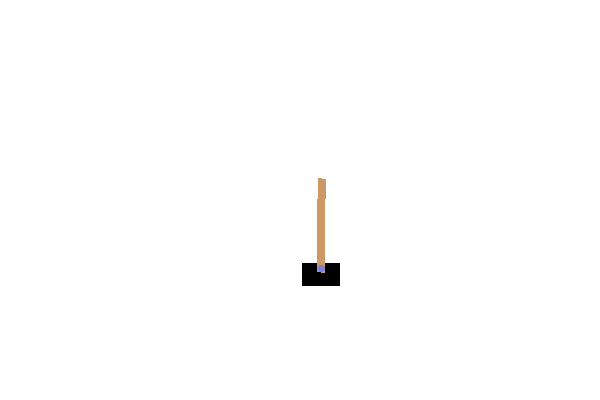
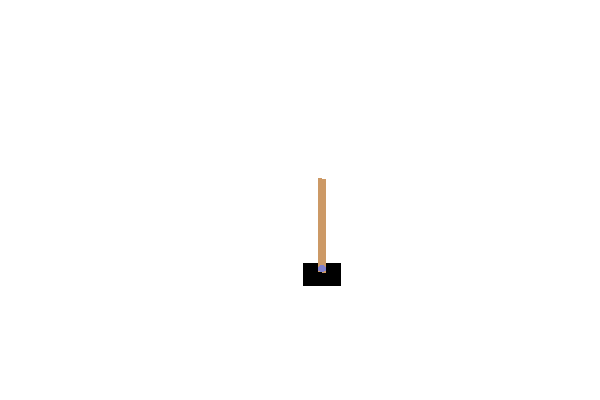
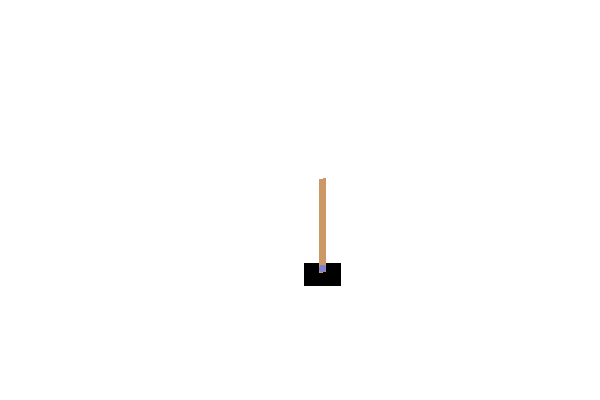
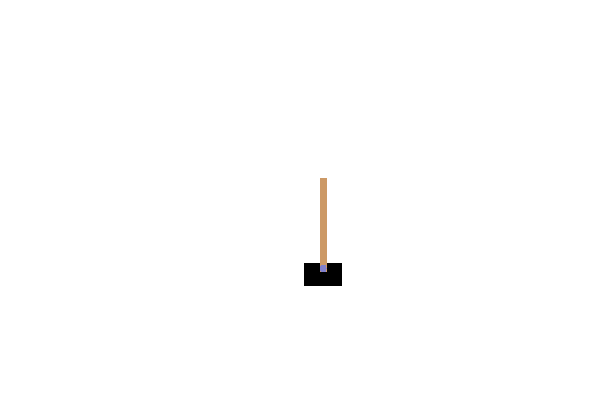
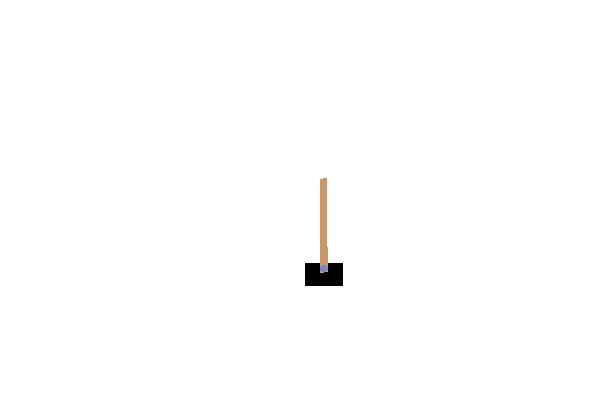
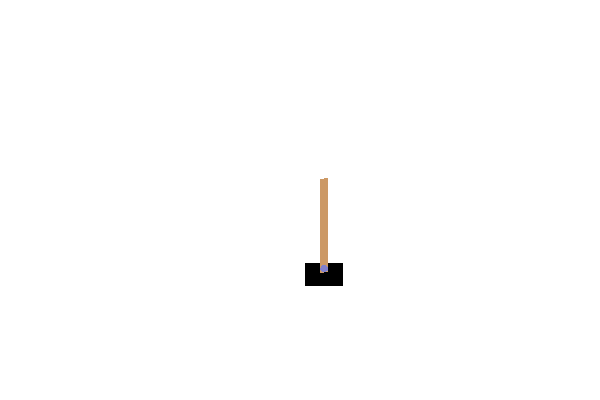
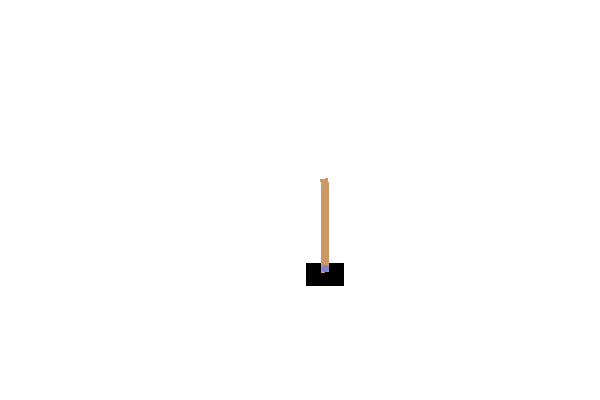
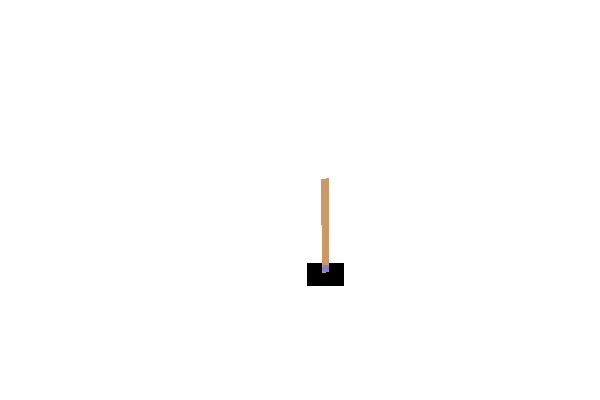
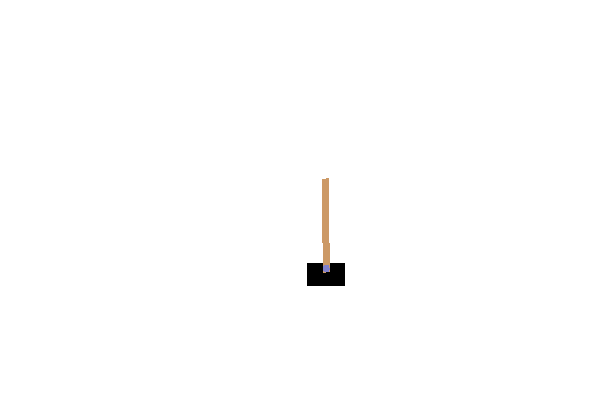
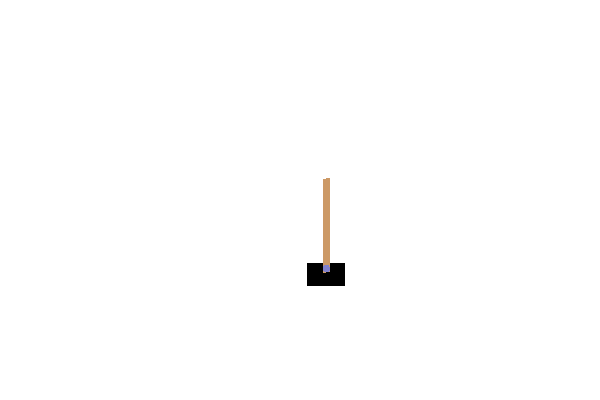
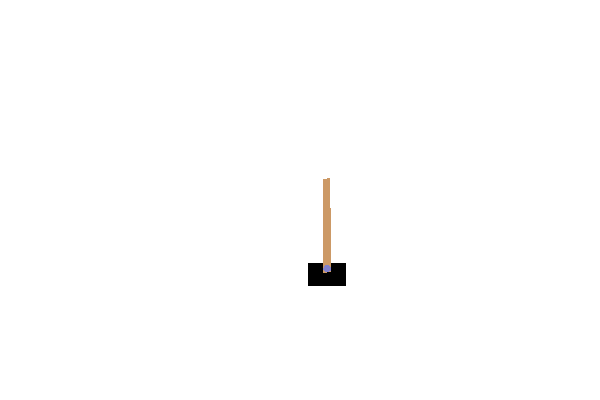
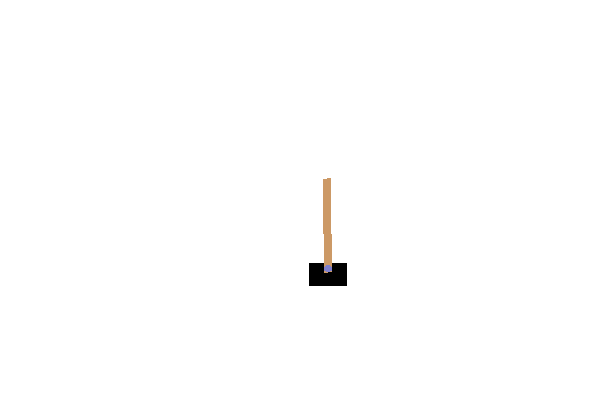
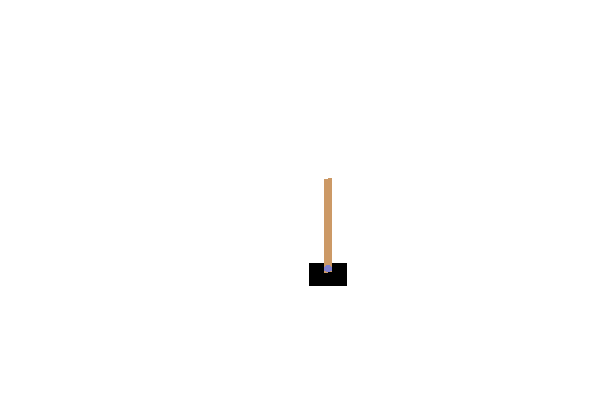
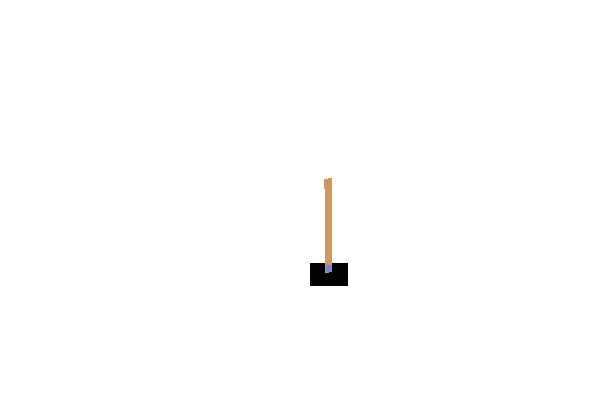
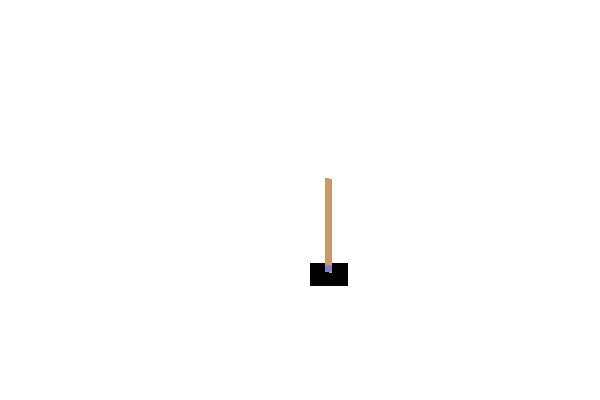
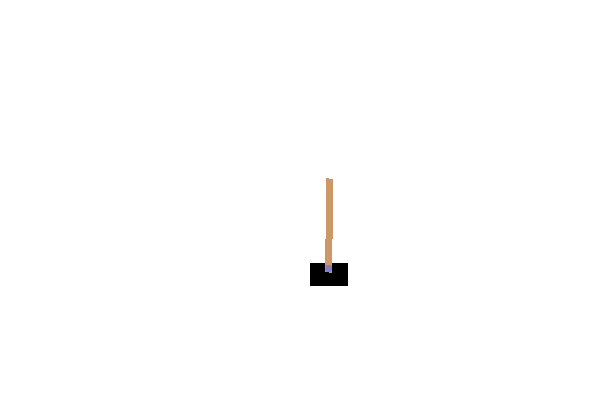
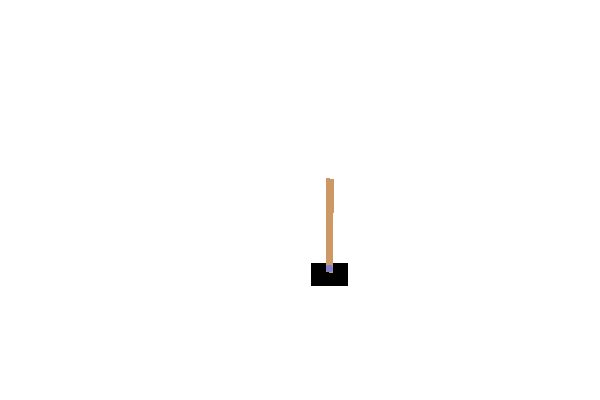
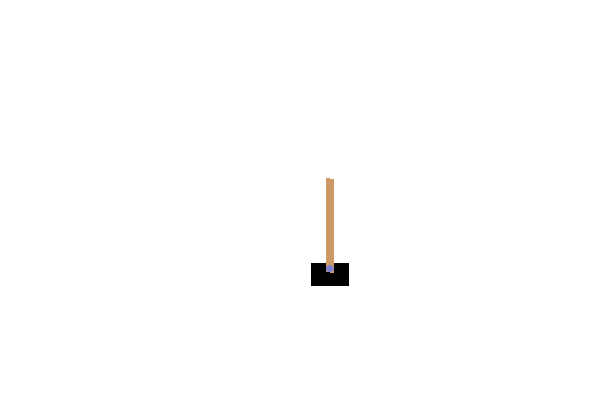
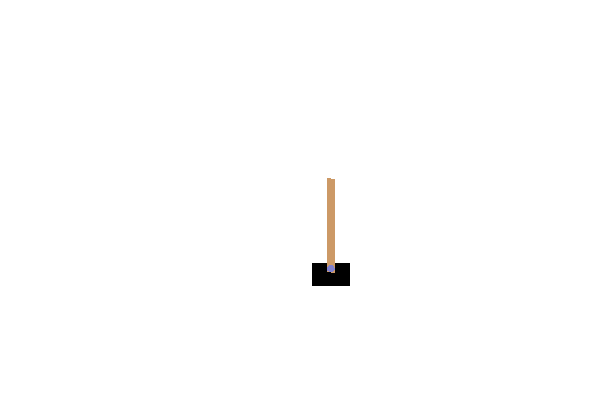
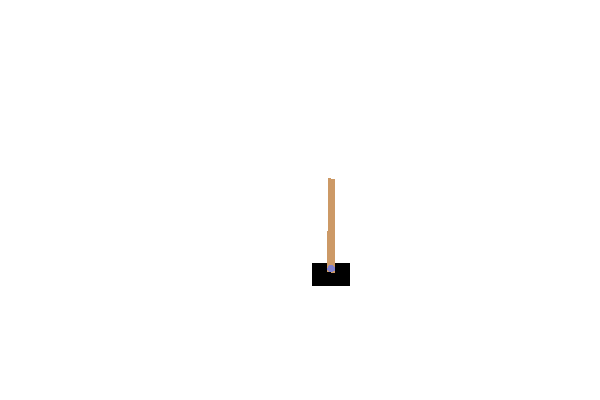
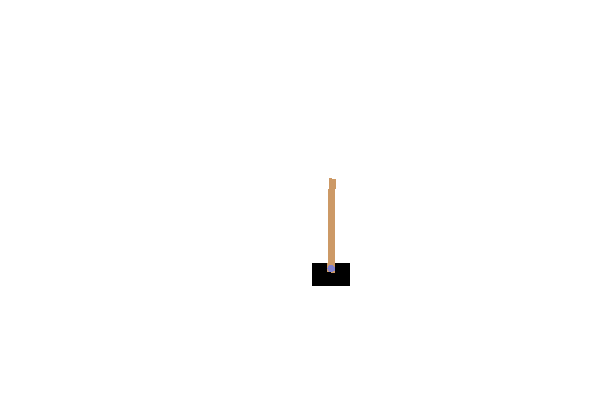
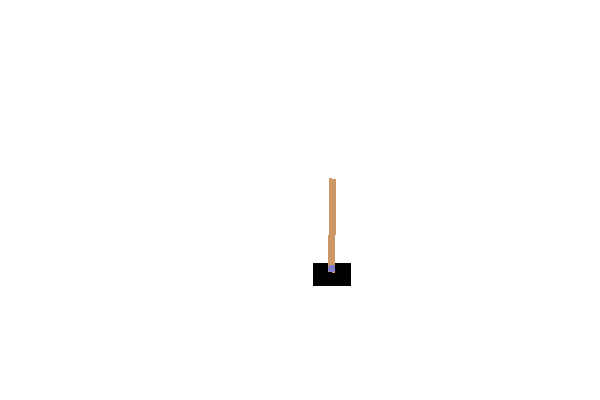
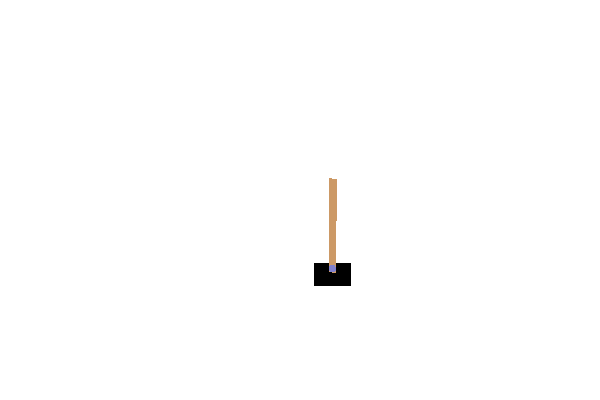
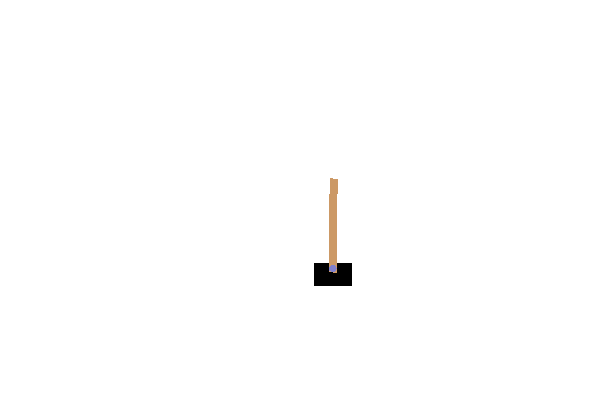
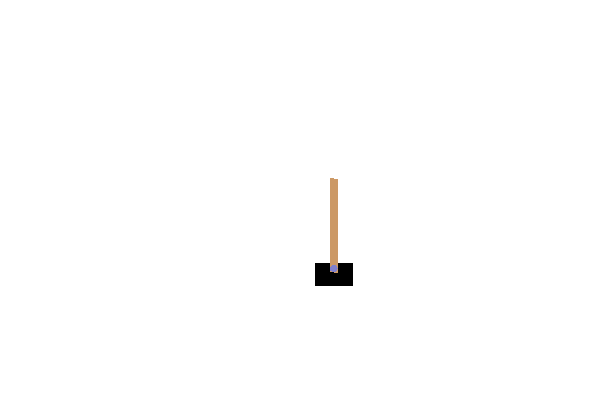
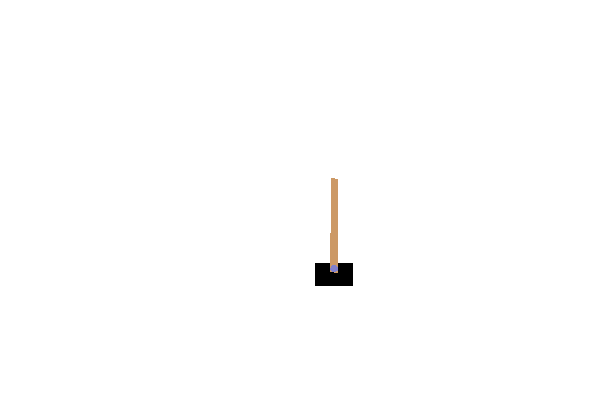
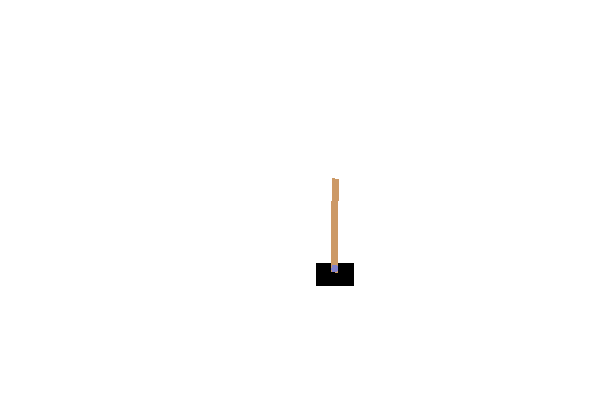
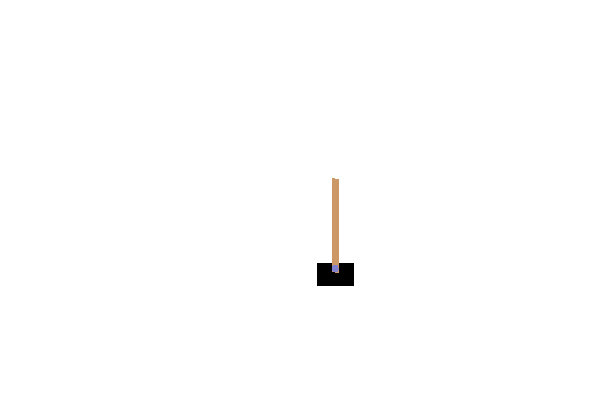
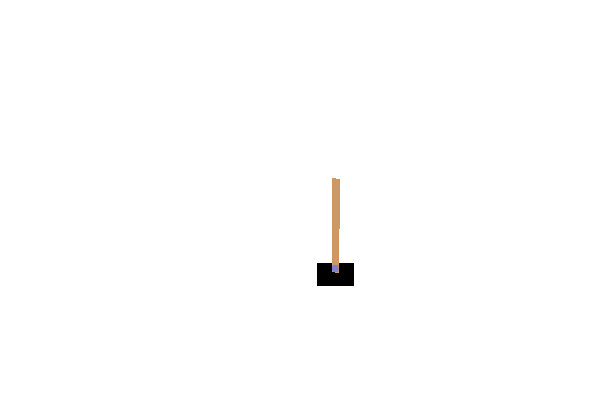
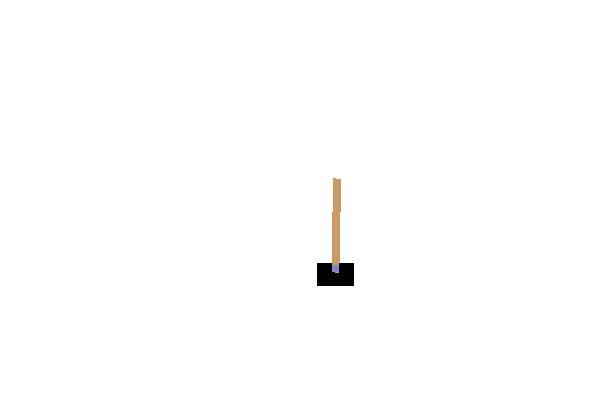
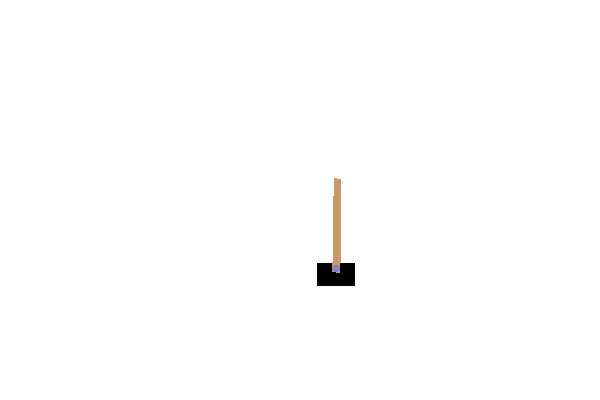
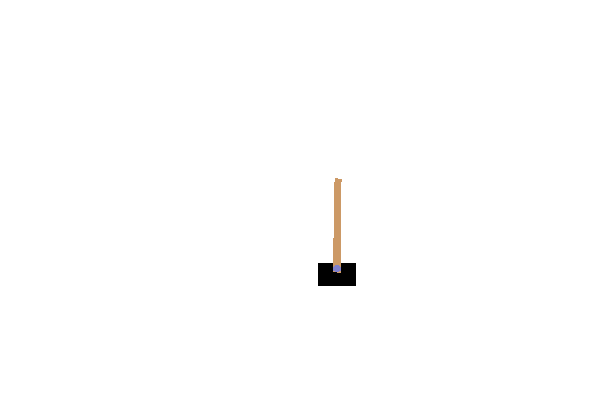
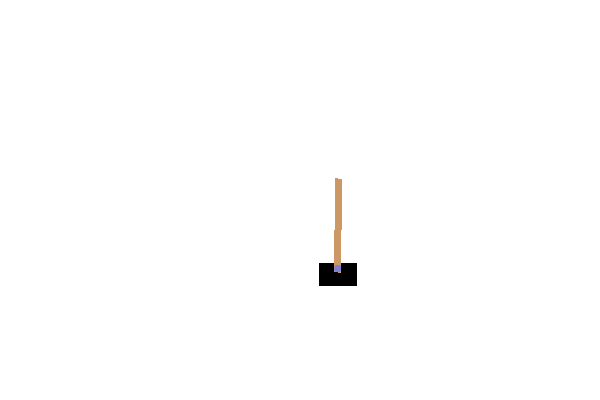
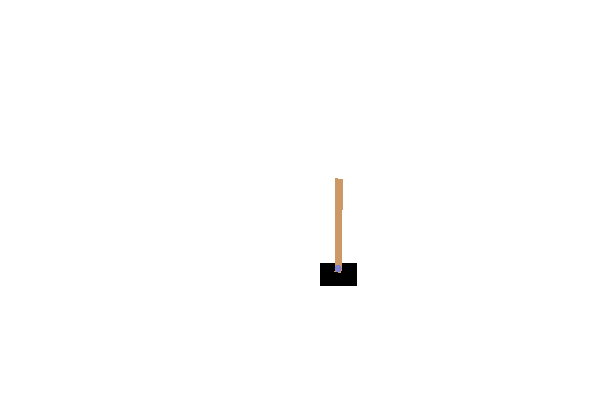
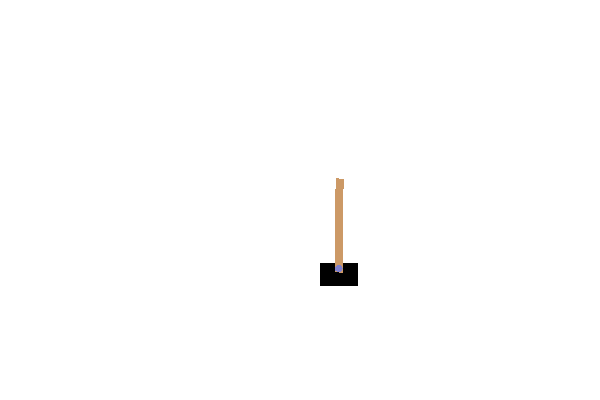
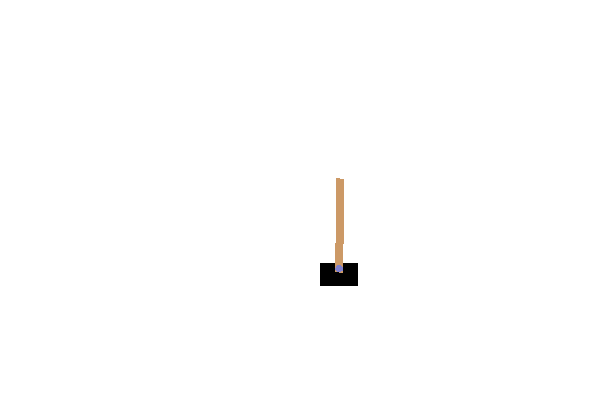
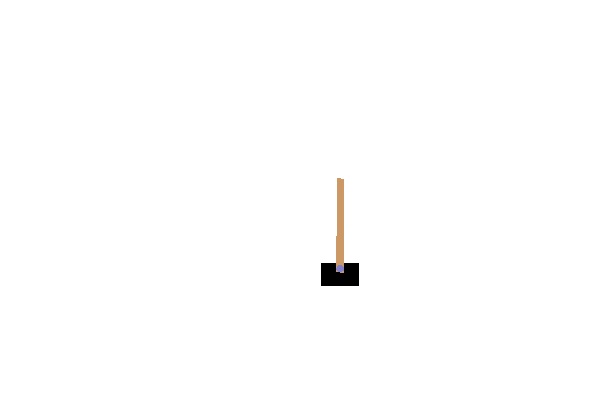
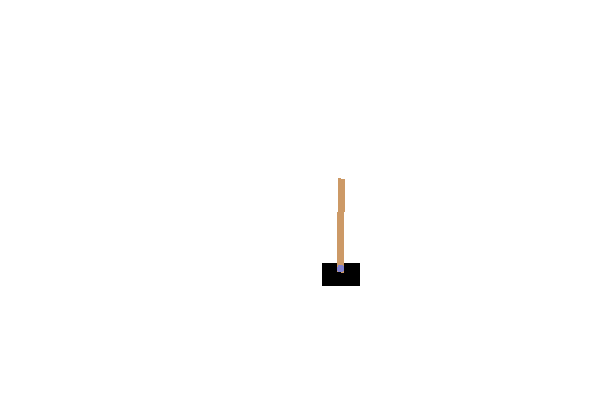
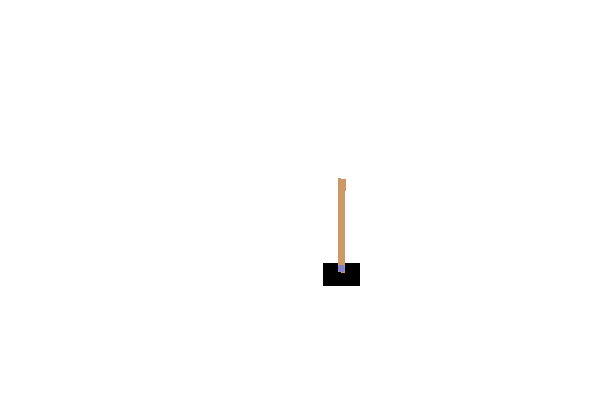
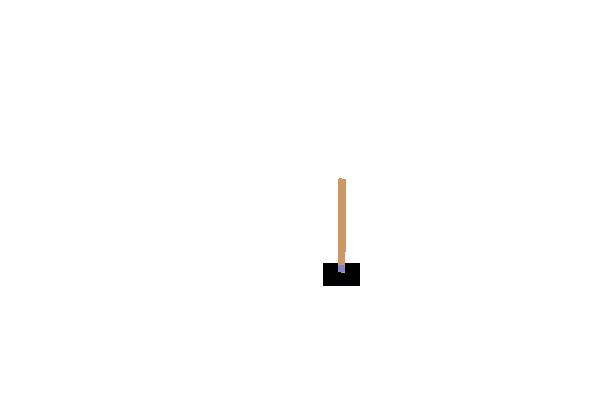
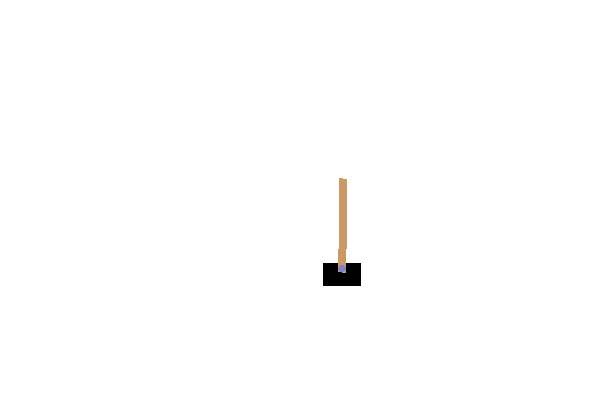
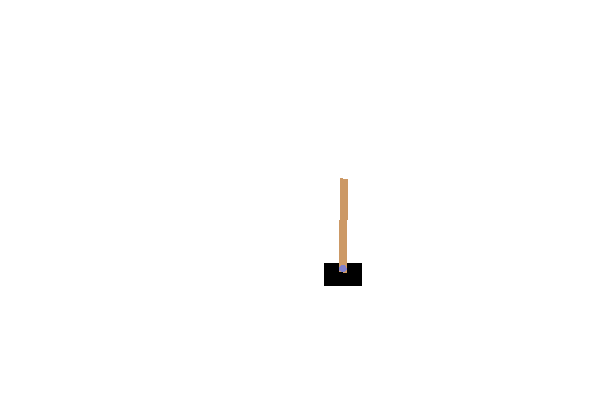
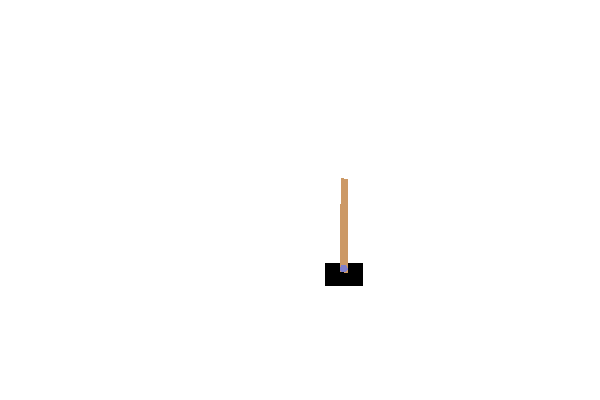
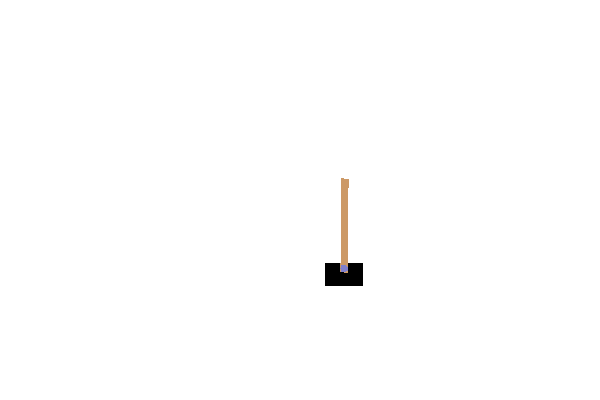
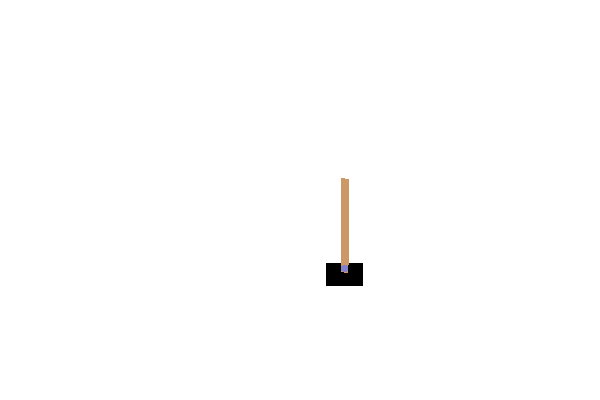
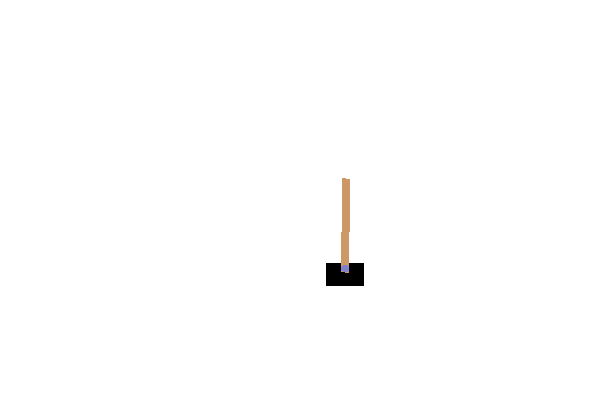
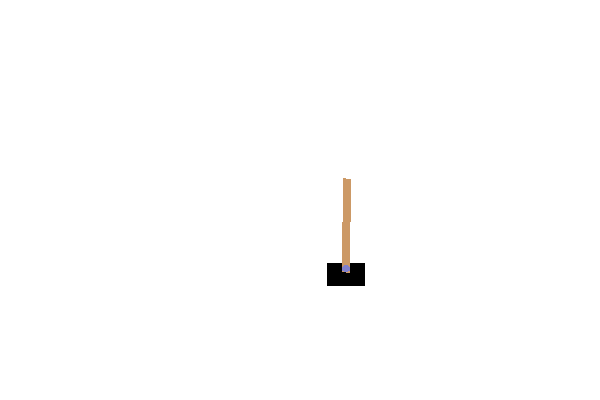
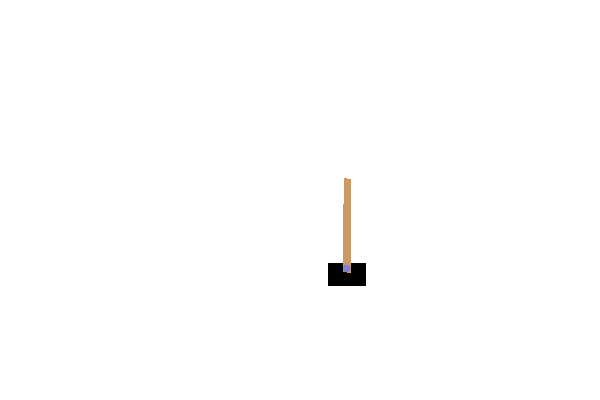
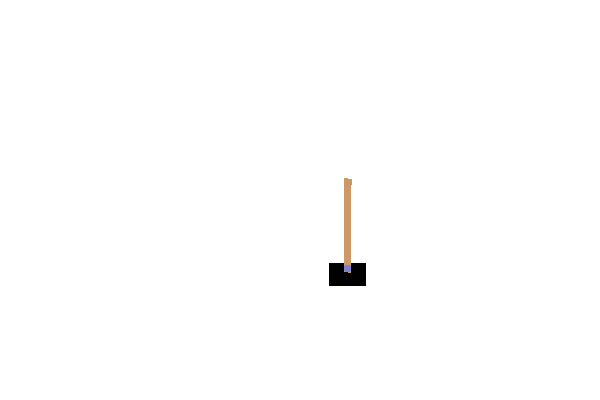
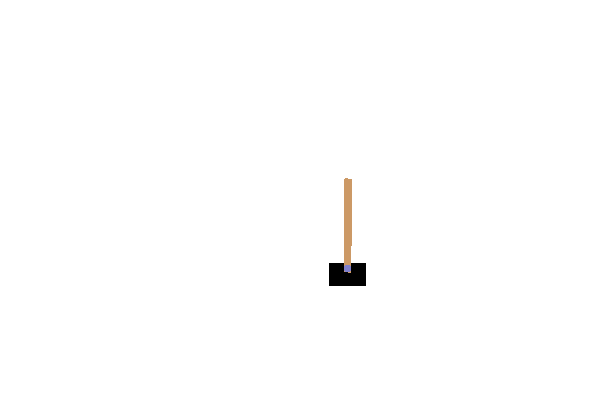
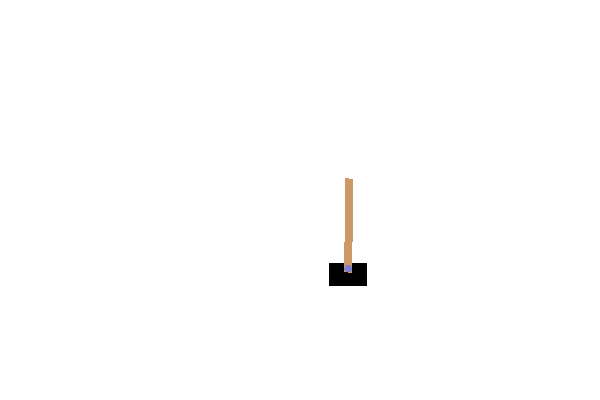
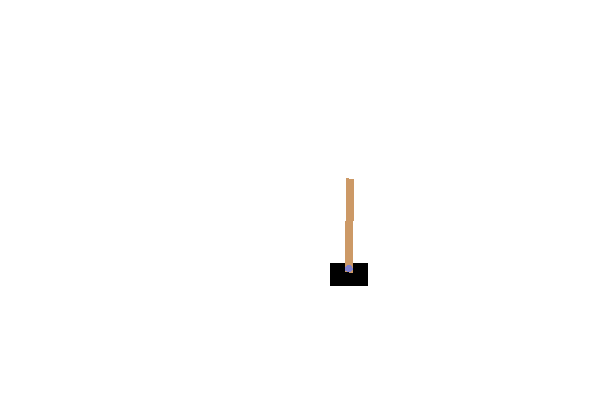
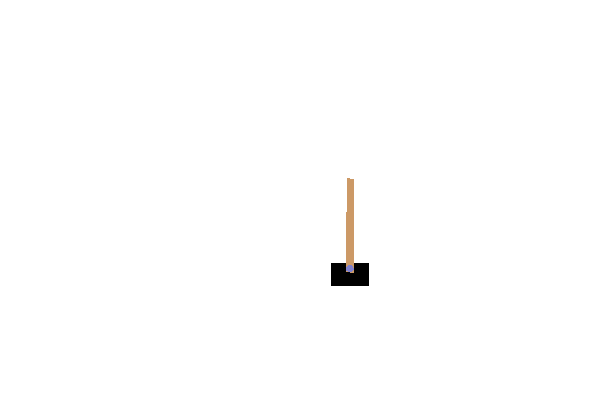
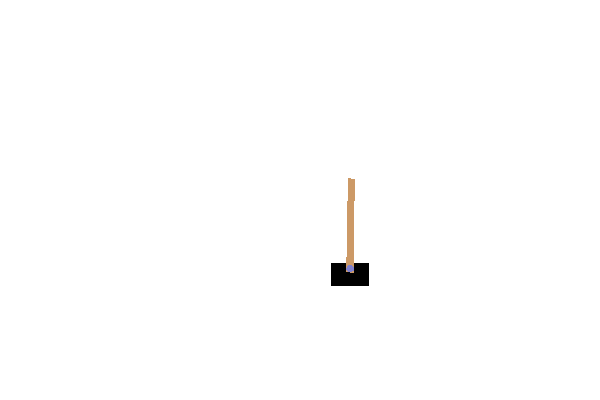
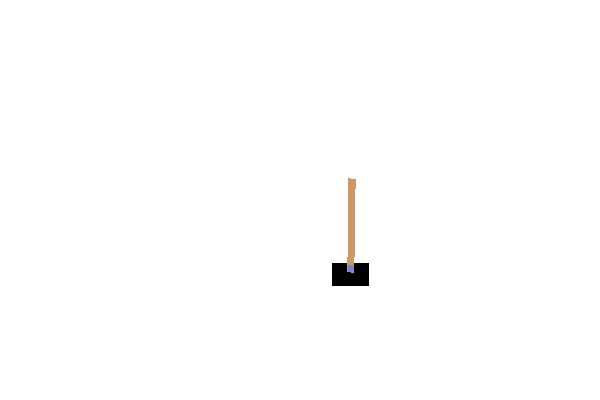
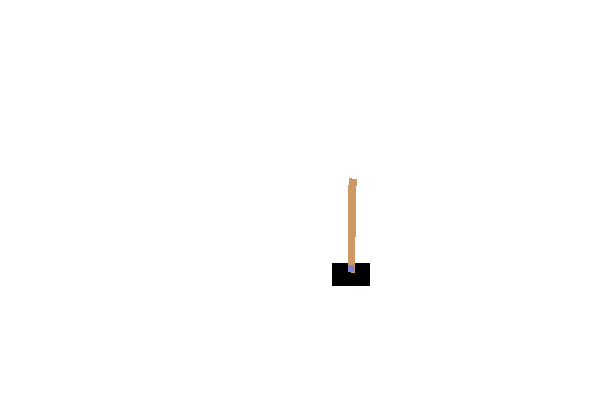
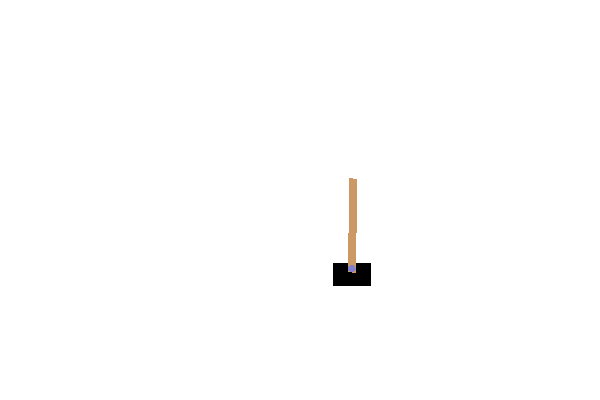
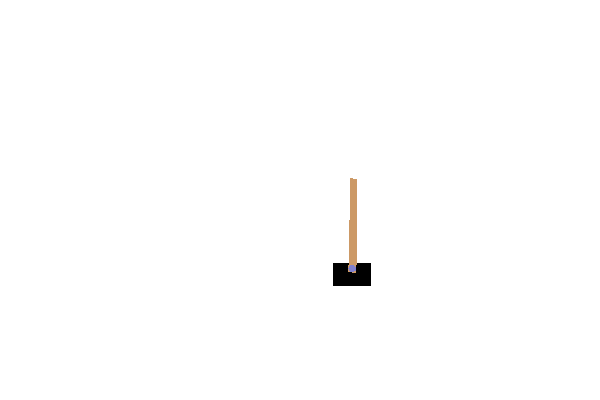
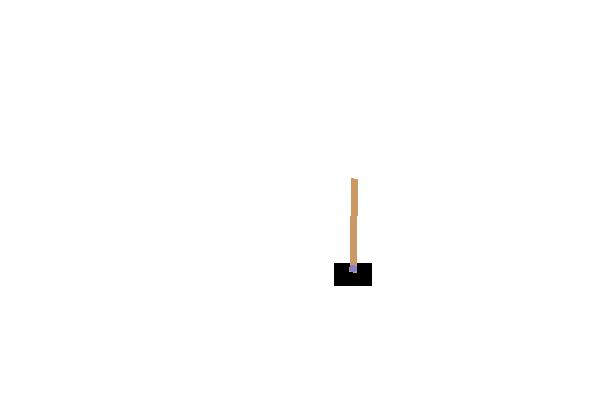
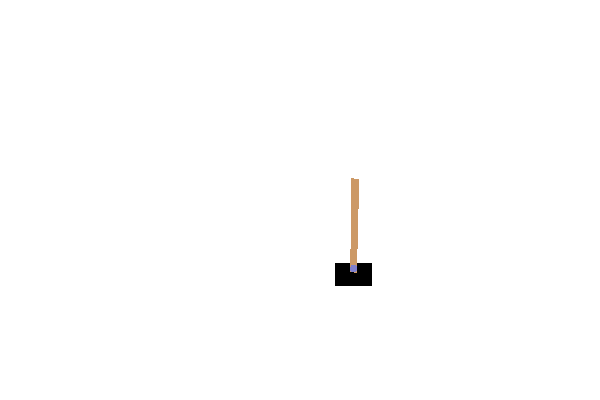
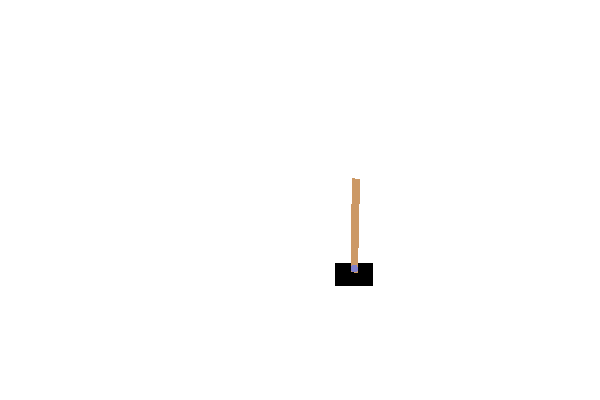
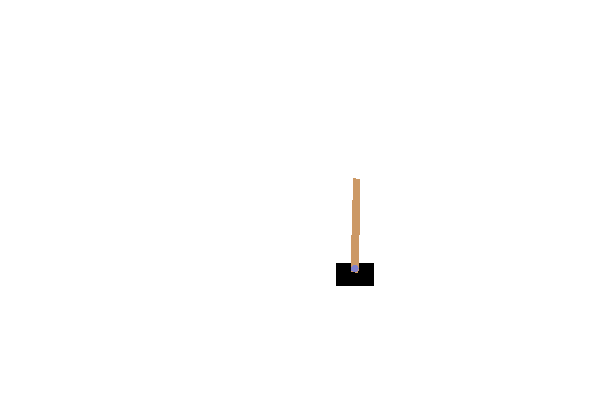
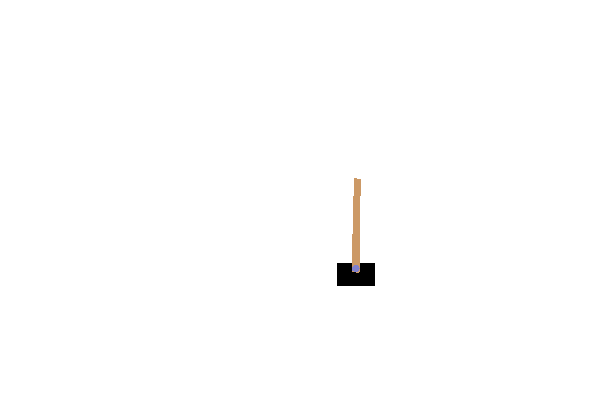
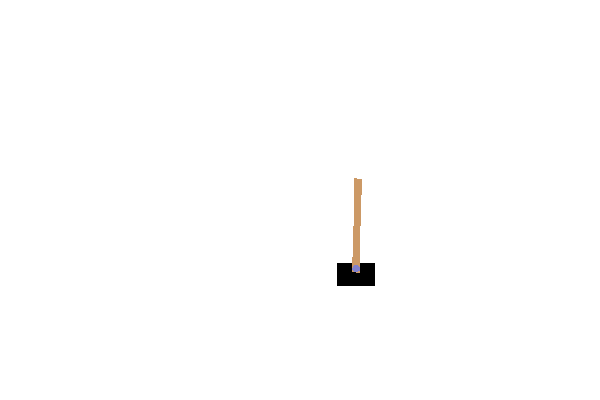
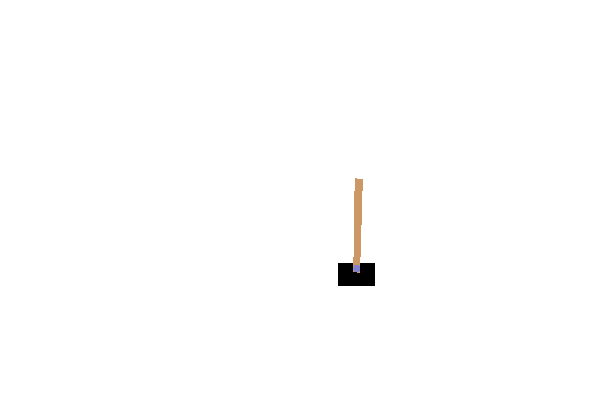
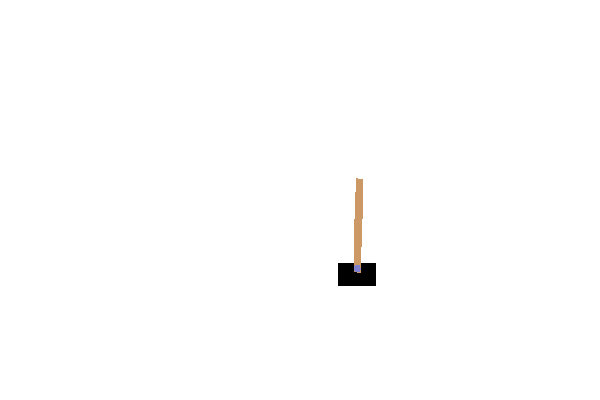
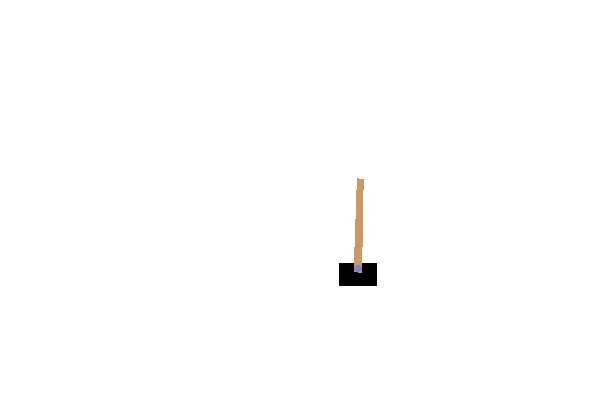
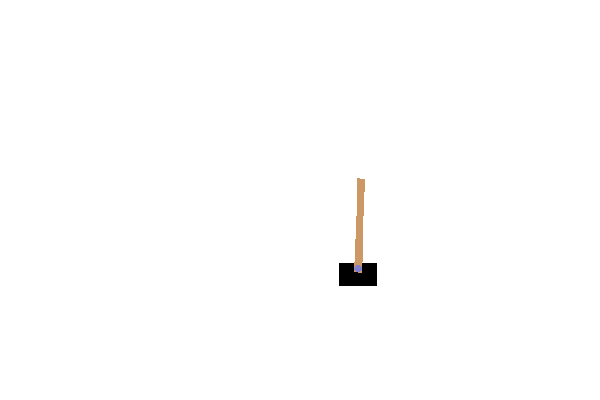
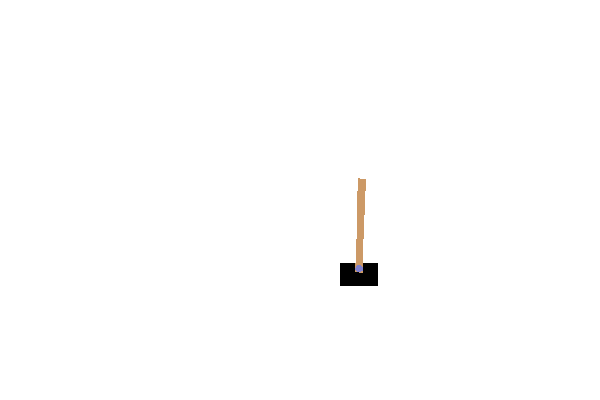
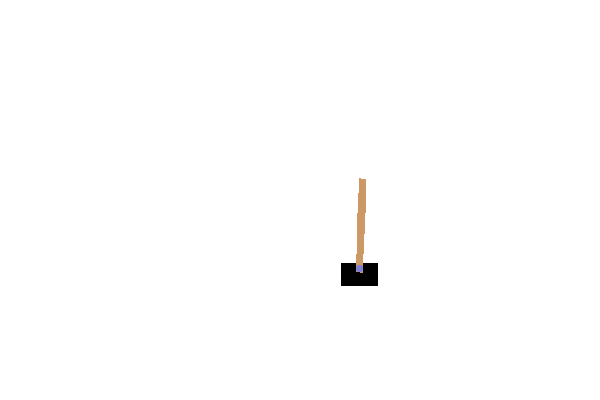
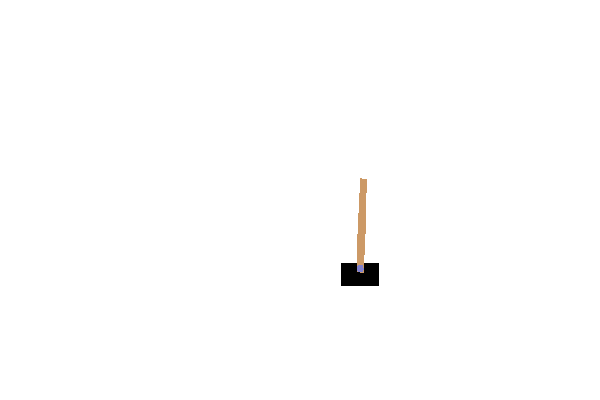
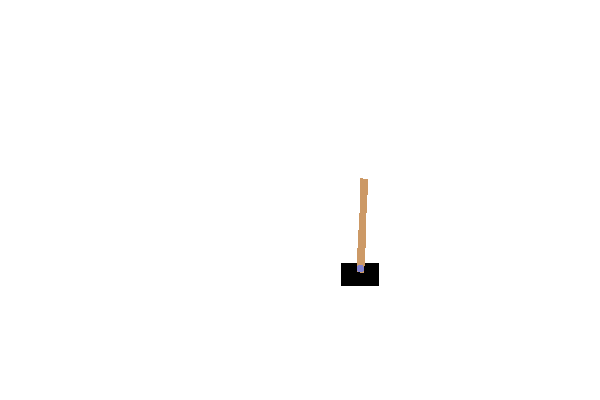
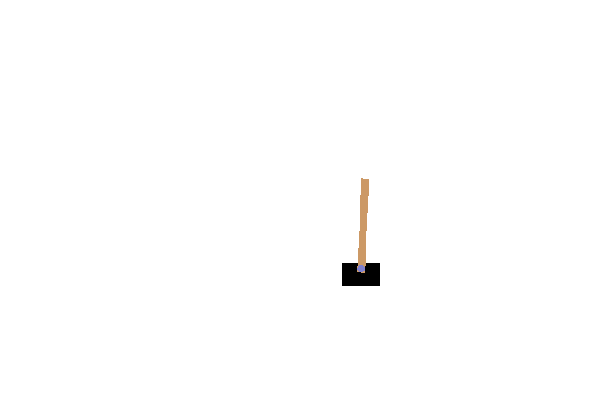
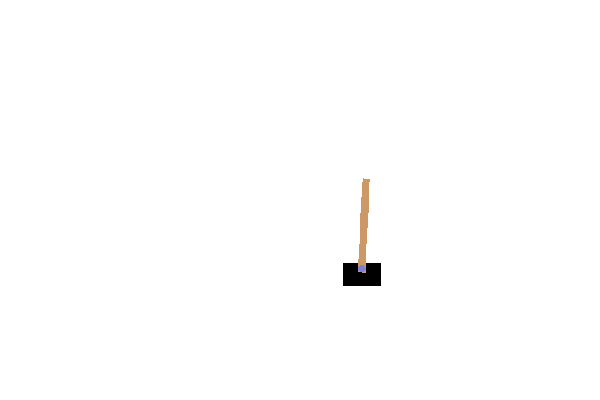
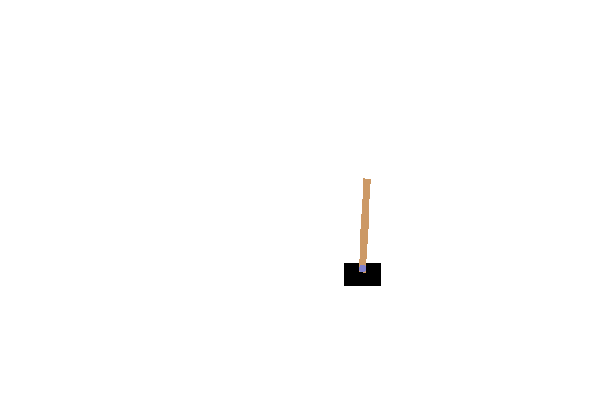
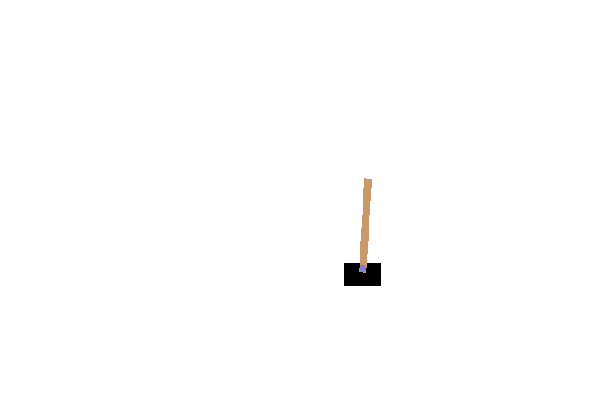
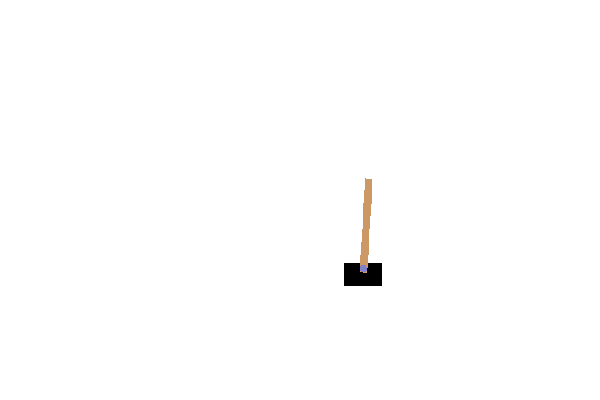
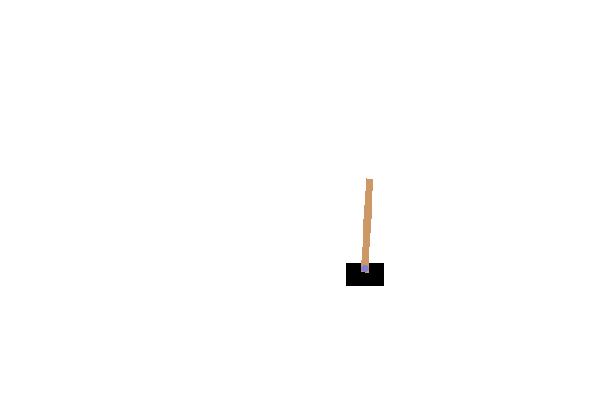
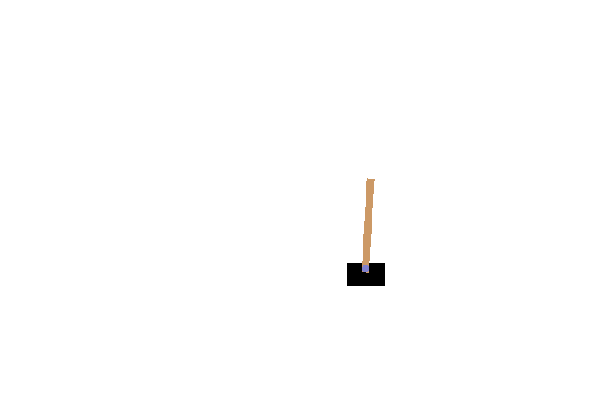
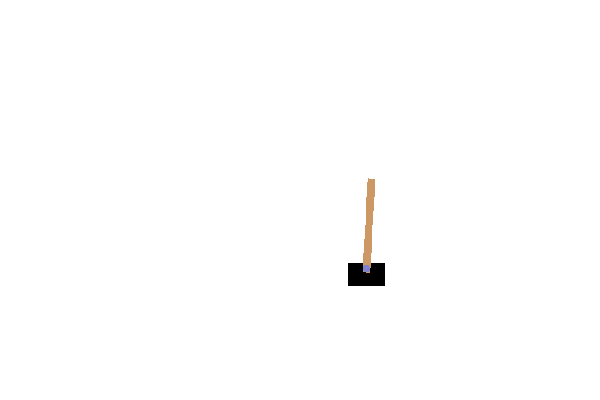
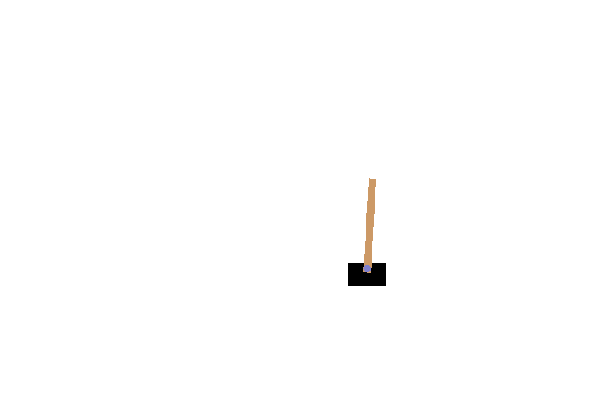
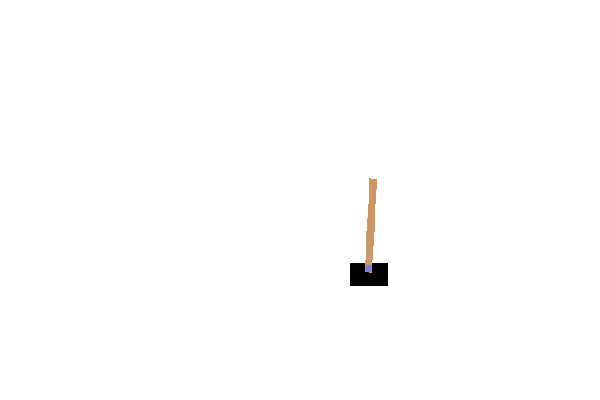
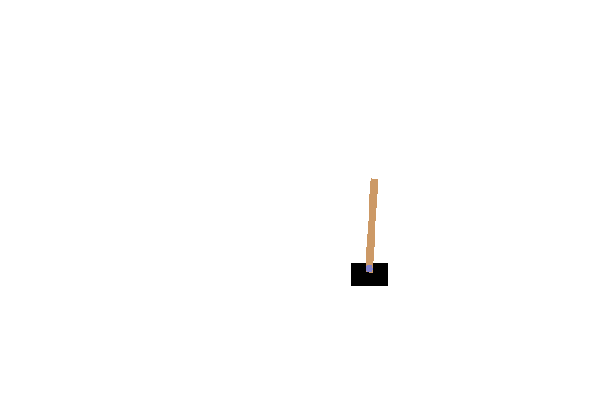
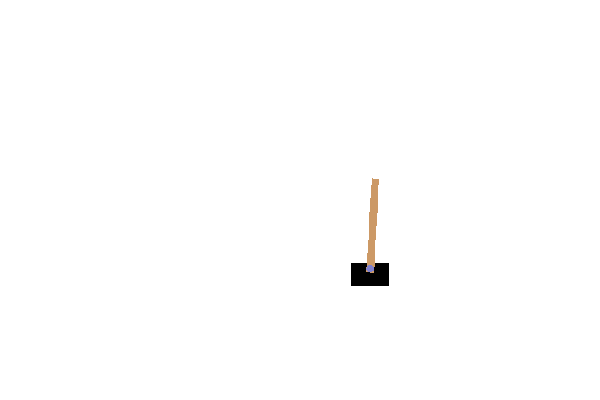
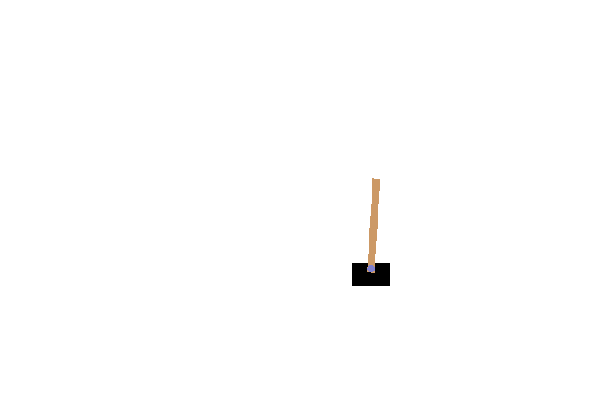
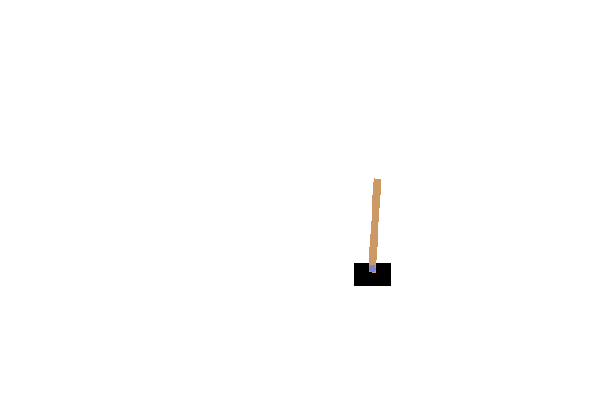
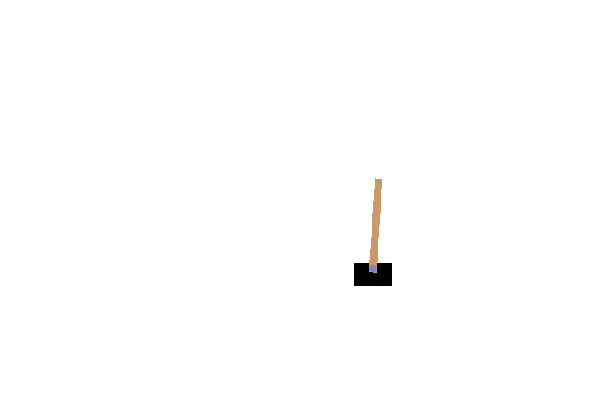
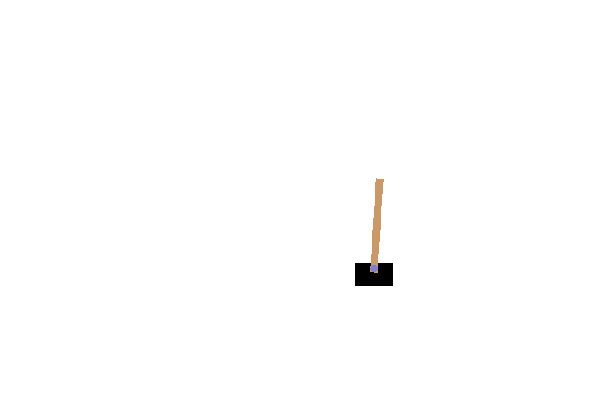
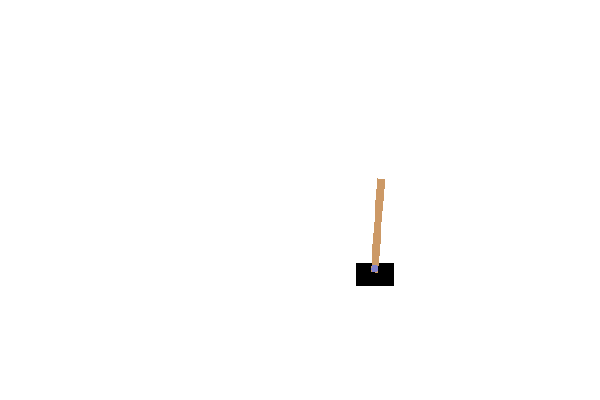
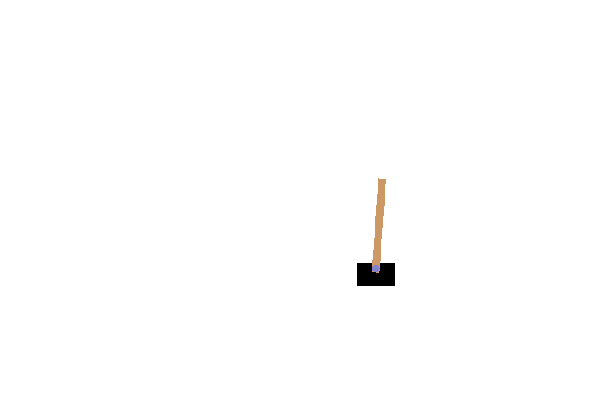
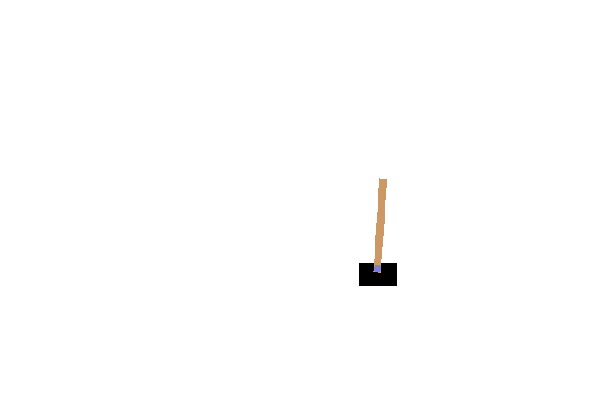
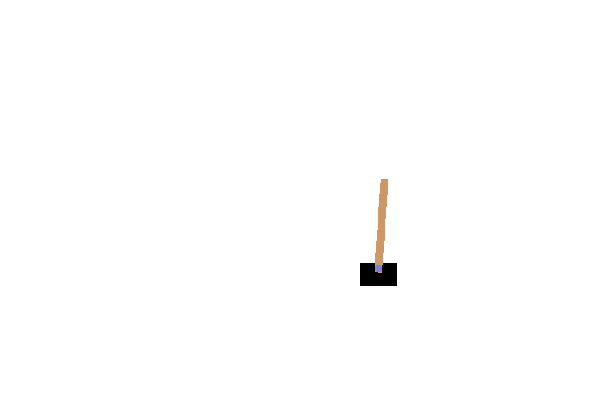
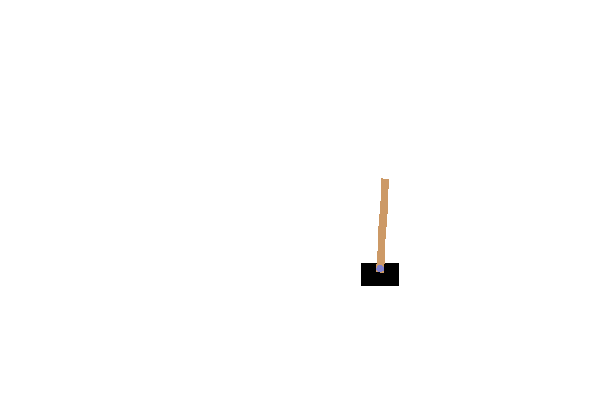
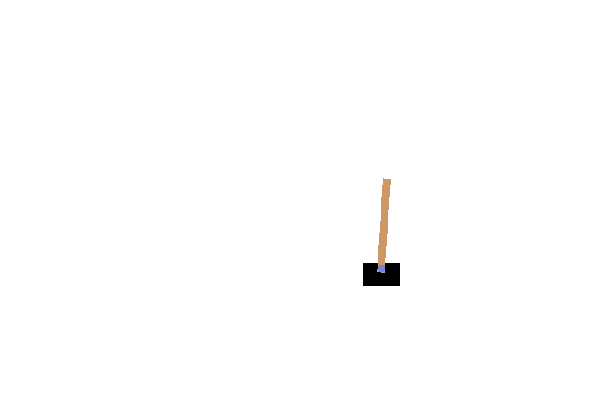
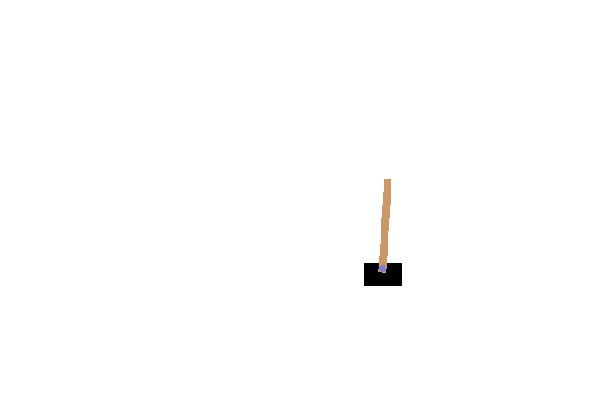
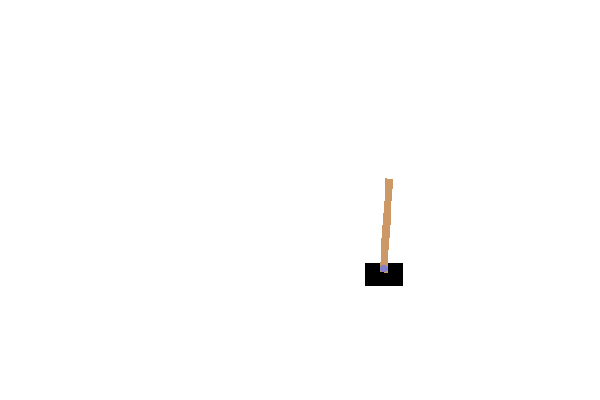
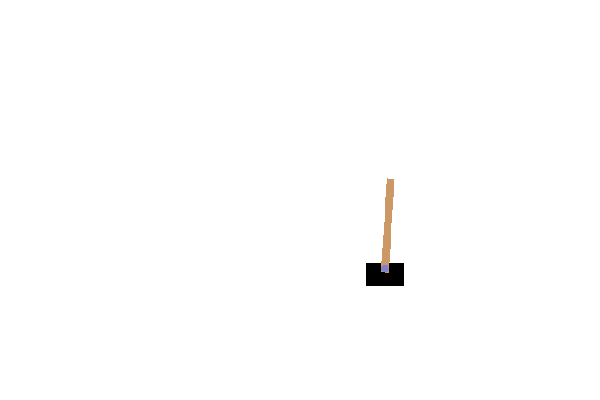
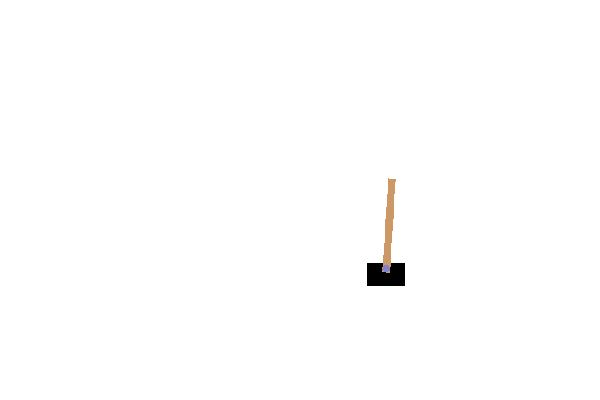
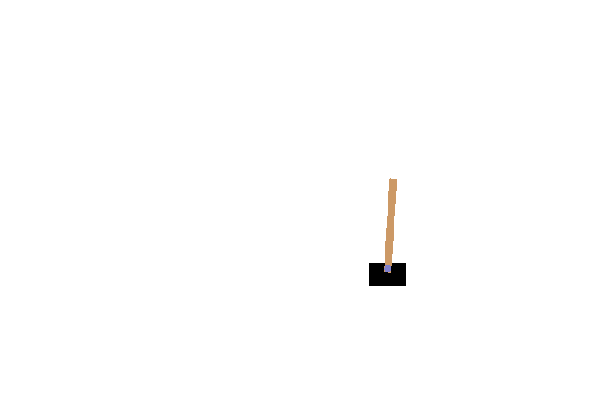
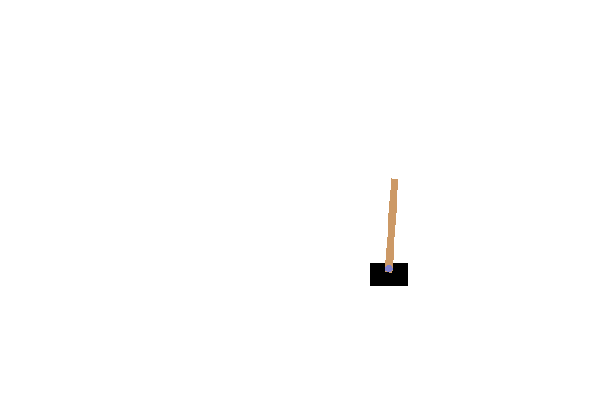
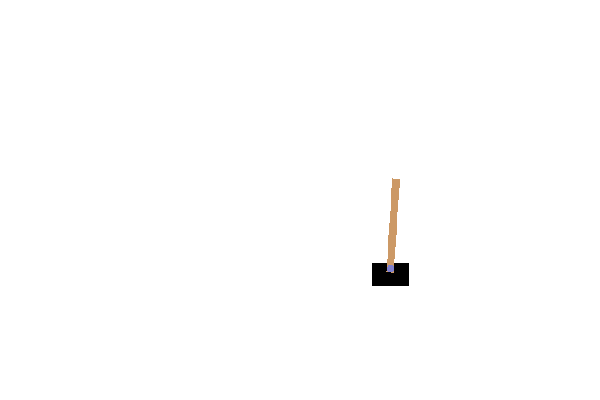
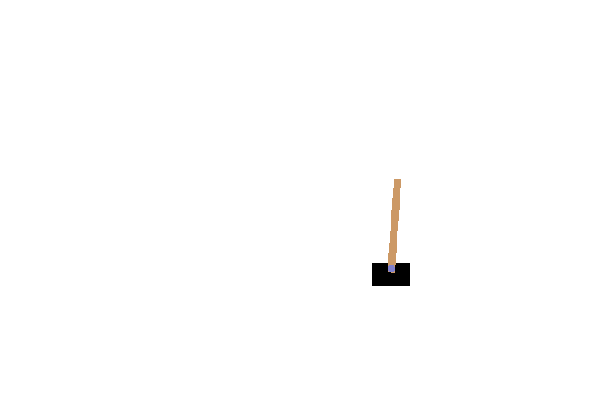
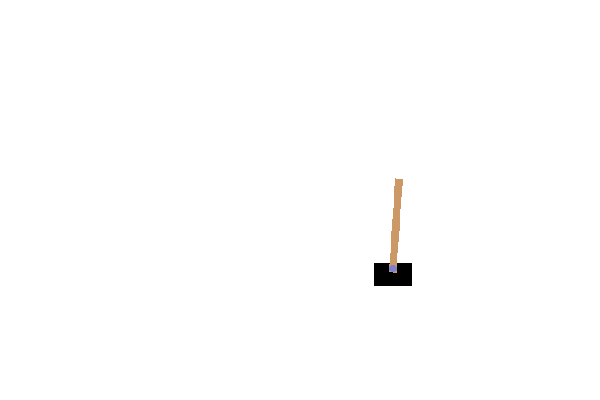
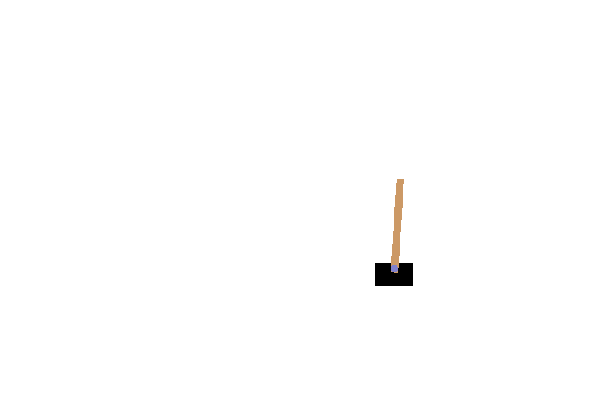
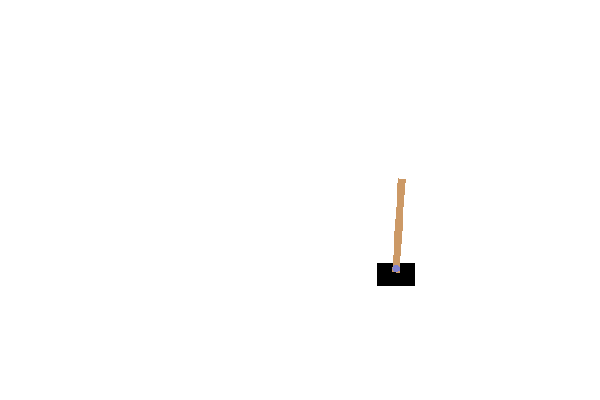
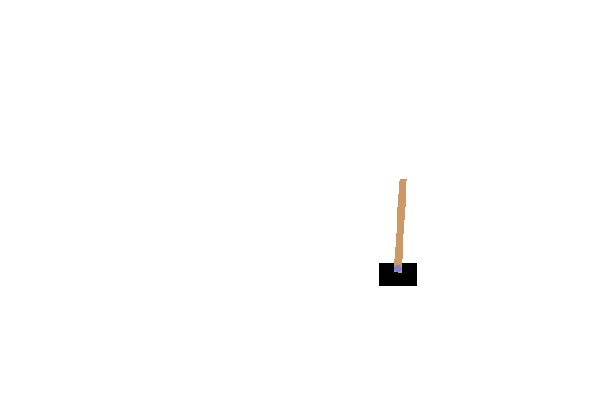
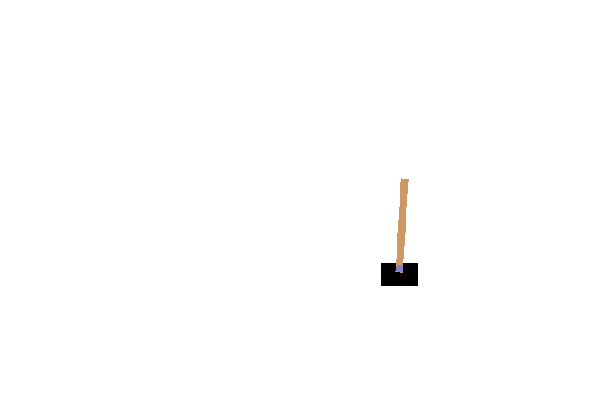
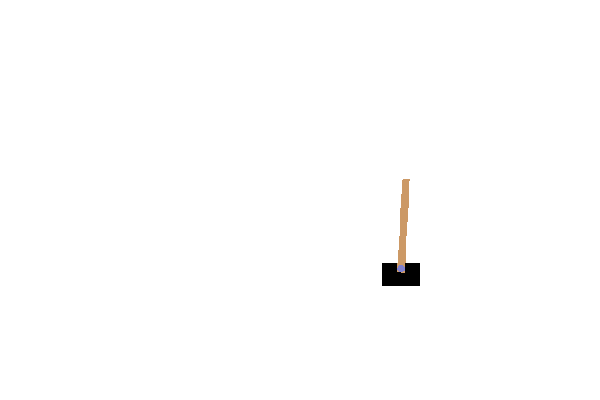
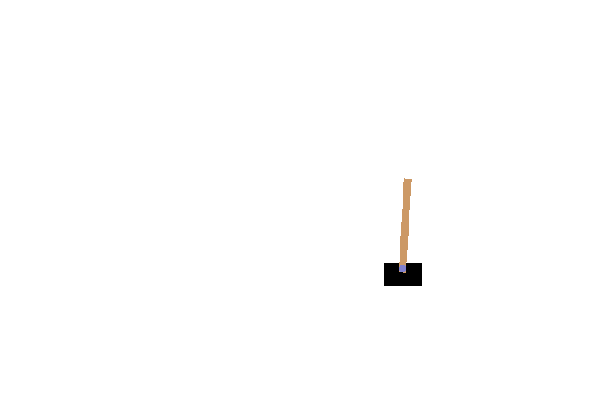
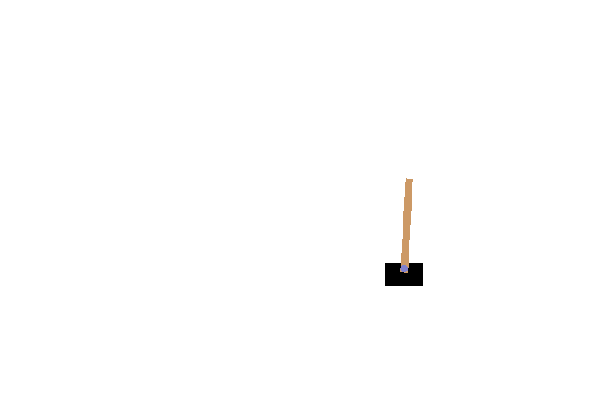
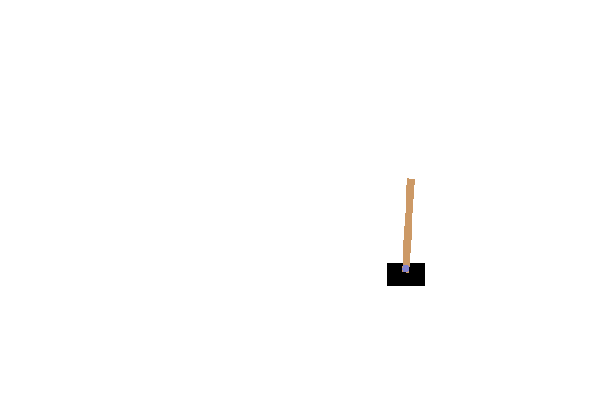
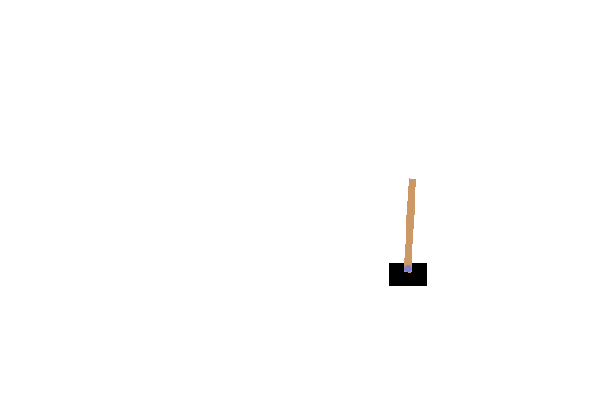
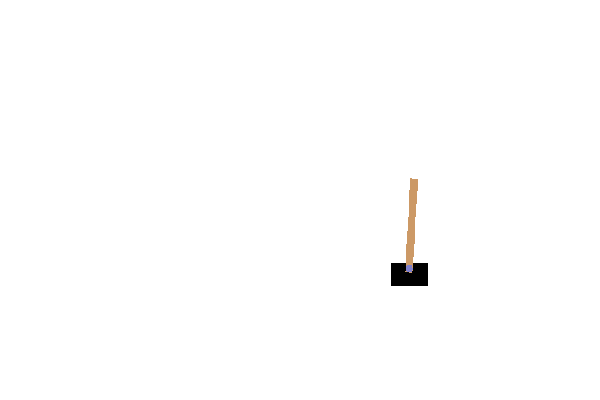
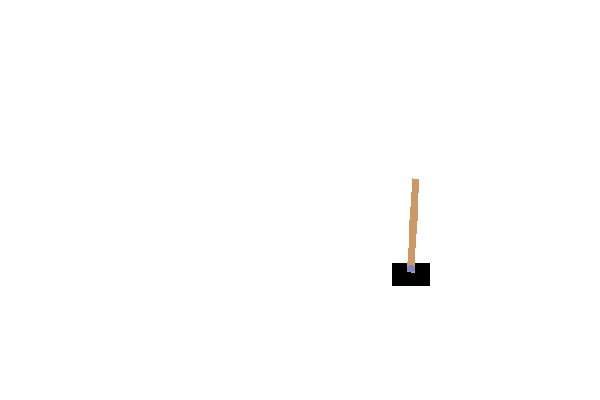
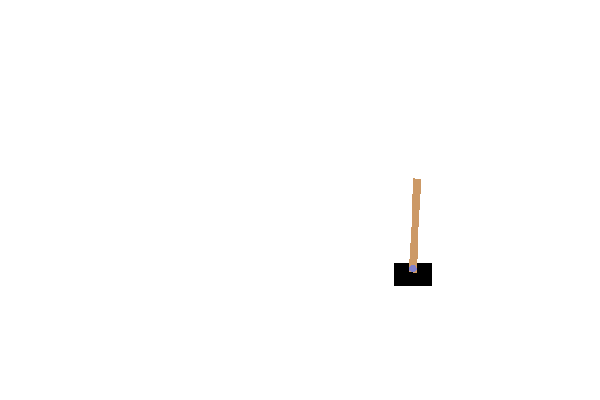
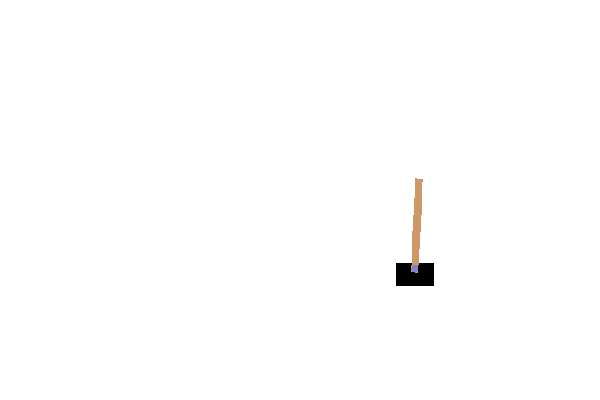
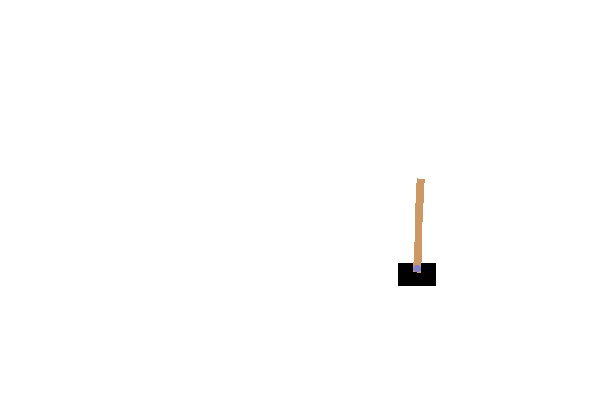
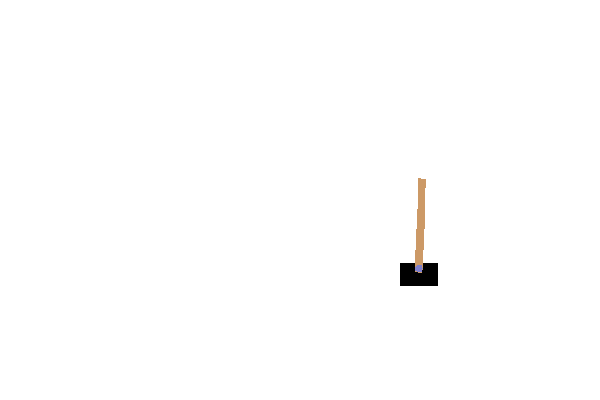
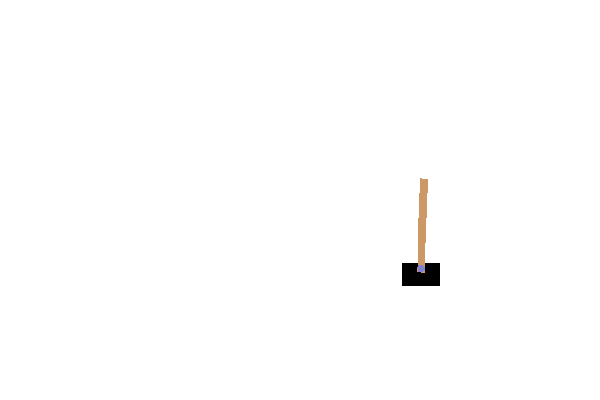
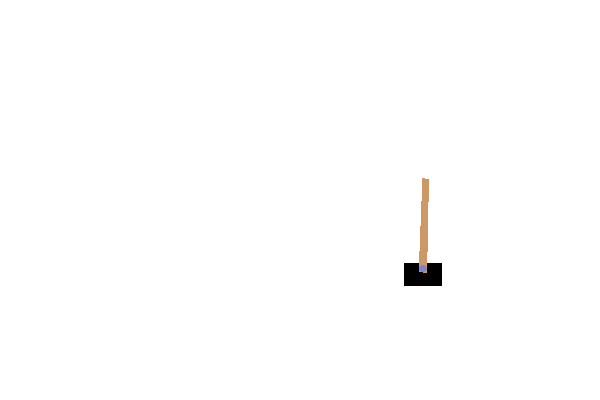
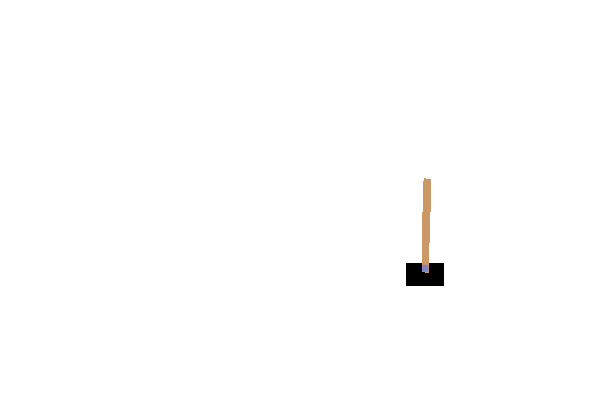
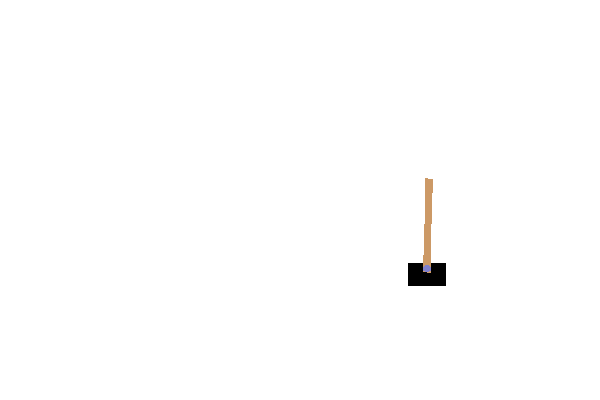
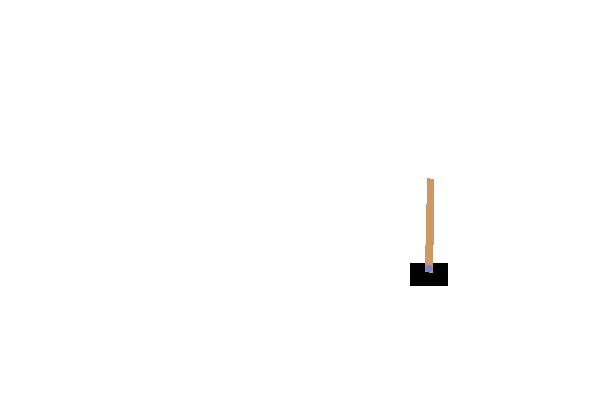
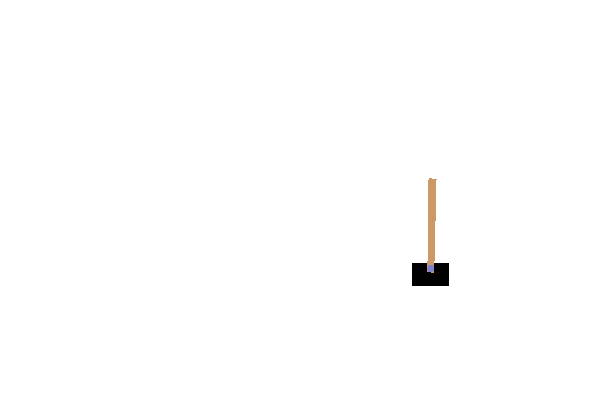
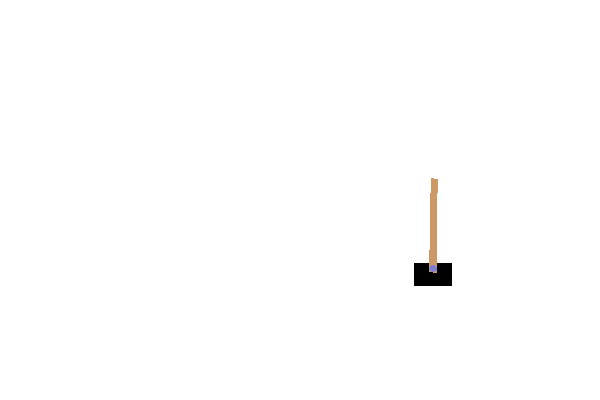
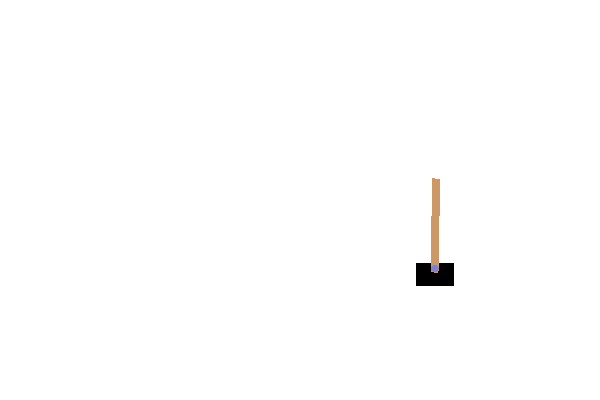
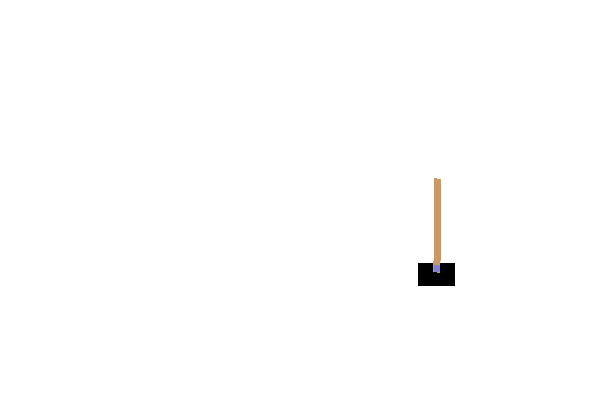
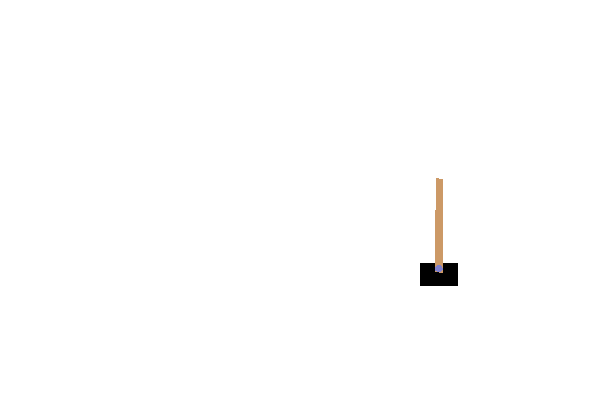
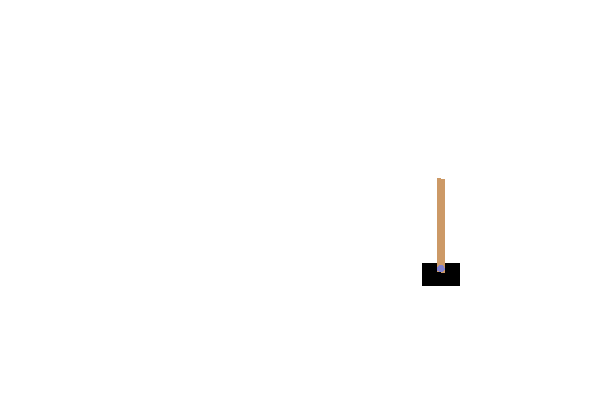
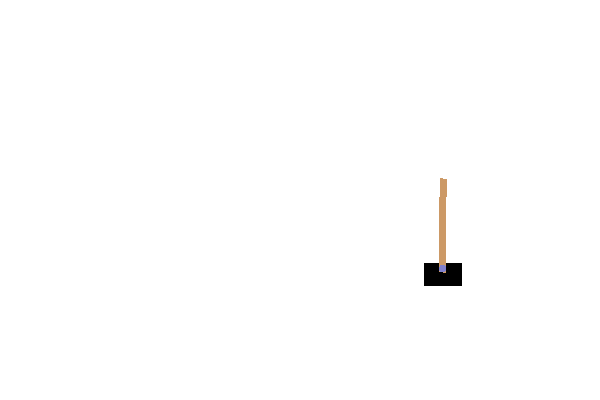
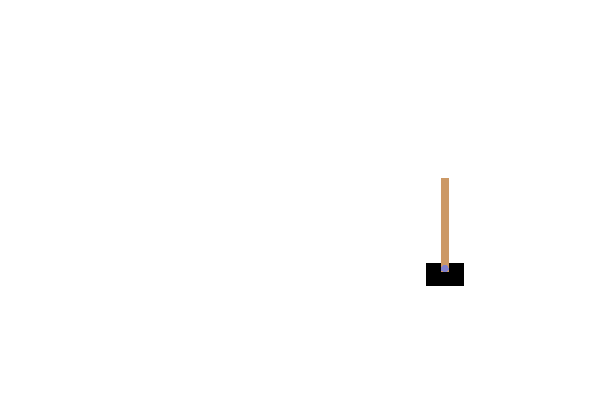
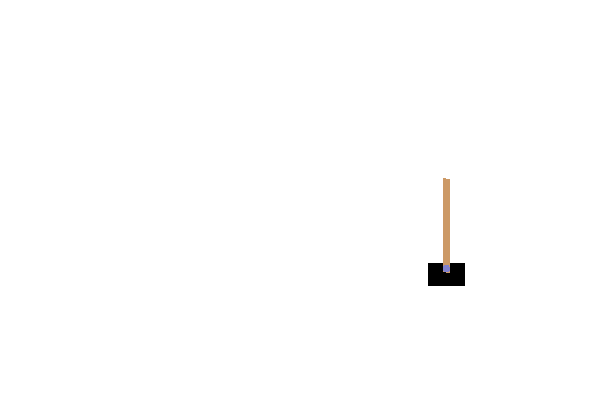
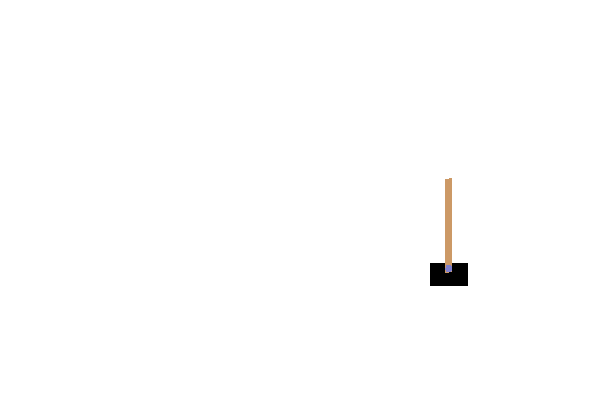

In [14]:
# main クラス
cartpole_env = Environment()
cartpole_env.run()